### Setup

In [1]:
import os
import sys
import datetime
import calendar
import itertools
import math
import time

import matplotlib.patheffects as path_effects
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms
import statsmodels.stats.stattools as smss
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model, unitroot
import warnings
warnings.warn = lambda *a, **kw: False
warnings.filterwarnings("ignore")

sys.path.append("..") # Adds higher directory to python modules path for importing from src dir
from src.datasets import NyseStocksDataset, NyseSecuritiesDataset, NyseFundamentalsDataset
import src.econometric_utils as eco
import src.regression_utils as regr
import src.plot_utils as plot
import src.math_utils as math_utils
import src.nlp_utils as nlp_utils
import src.utils as utils

import networkx as nx
# https://networkx.github.io/documentation/stable/tutorial.html
import visJS2jupyter
import visJS2jupyter.visJS_module as visJS_module
# http://compbio.ucsd.edu/bringing-interactivity-network-visualization-jupyter-notebooks-visjs2jupyter/


get_month = lambda i: datetime.date(2000, int(i), 1).strftime('%B')
get_weekday = lambda i: calendar.day_name[int(i)]
split = lambda x: (x.iloc[:600], x.iloc[600:])  # train: 2010-01-05 until 2012-05-21, val: 2012-05-21 until 2012-12-31

TRAIN_FRAME = pd.to_datetime('2010-01-05'), pd.to_datetime('2012-05-21')
VAL_FRAME = pd.to_datetime('2012-05-22'), pd.to_datetime('2012-12-31')
TEST_FRAME = pd.to_datetime('2012-05-22'), pd.to_datetime('2012-12-31')

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

In [2]:
stocks = NyseStocksDataset('OCMvOC-3C', file_path='../data/nyse/prices-split-adjusted.csv', features=['open', 'close', 'movement', 'vix_open', 'vix_close'], load=True, incl_test=True, look_back=1)
securities = NyseSecuritiesDataset(file_path='../data/nyse/securities.csv', load=True)
fundamentals = NyseFundamentalsDataset(file_path='../data/nyse/fundamentals.csv', load=True)


time: 17.1 s


In [3]:
gspc = stocks.load_gspc().set_index('date')[['gspc_open', 'gspc_close']].rename(lambda x: x.replace('gspc_', ''), axis=1)
gspc = eco.add_movements(gspc)

vix = stocks.load_vix().set_index('date')[['vix_open', 'vix_close']].rename(lambda x: x.replace('vix_', ''), axis=1)
vix = eco.add_movements(vix)

prices = stocks.enhance_features(stocks.prices.copy())
comp_metas, train_comp_prices, val_comp_prices = [], [], []
comp_grouped = prices.groupby(prices.symbol, sort=False)
for sym, p in tqdm(comp_grouped):
    if not stocks.is_company_available(sym):
        continue
    whole_p = eco.add_movements(p).drop(columns=['symbol', 'movement']).set_index('date')
    train_comp_prices.append(whole_p)
#     train, val = split(whole_p)
#     assert train.index.min() == TRAIN_FRAME[0] and train.index.max() == TRAIN_FRAME[1], f'Shape not matching for {sym}'
#     assert val.index.min() == VAL_FRAME[0] and val.index.max() == VAL_FRAME[1], f'Shape not matching for {sym}'
#     train_comp_prices.append(train)
#     val_comp_prices.append(val)
    comp_metas.append({'symbol': sym, 'industry': securities.get_industry(sym), 'name': securities.get_company_name(sym)})

comp_metas = pd.DataFrame(comp_metas)

KeyboardInterrupt: 

time: 16.7 s


### Select Industry

In [ ]:
def get_industry(ind_name, val=False):
    indizes = comp_metas.index[comp_metas.industry == ind_name]
    for i in indizes:
        _, name, symbol = comp_metas.iloc[i]
        if val:
            yield symbol, name, val_comp_prices[i]
        else:
            yield symbol, name, train_comp_prices[i]

all_industries = comp_metas.industry.unique()
print('Industries:', ', '.join(all_industries))

In [ ]:
# Calculate movements per industry to normalize stock prices
ind_means = pd.DataFrame([pd.DataFrame([p.boxcox for _, _, p in get_industry(i)]).mean() for i in all_industries], index=all_industries).T
# ind_means_val = pd.DataFrame([pd.DataFrame([p.boxcox for _, _, p in get_industry(i, val=True)]).mean() for i in all_industries], index=all_industries).T
# (ind_means.T - gspc.boxcox[ind_means.index]).T.corr()

pd.Series([len(list(get_industry(x))) for x in all_industries], index=all_industries)

In [ ]:
# e.g. greatest energy companies: XOM, CHK
industry_name = 'Energy'  # 'Information Technology'
industry = list(get_industry(industry_name))
industry_val = list(get_industry(industry_name, val=True))
greatest_comp = np.argmax([(p.volume.max()) for _, _, p in industry])
(symbol, name, price), val_price = industry[greatest_comp], industry_val[greatest_comp][2]

Shapiro test (null=normal): p value = 0.0020
Shapiro test (null=normal): p value = 0.0026
Shapiro test (null=normal): p value = 0.4177

Test for Distributions Equality:
>Kolmogorov-Smirnov (null = equal): p value = 1.0000
>Kruskal-Wallis (null = equal): p value = 0.9380
>Mann-Whitney (null = equal): p value = 0.4690

Test for Distributions Equality:
>Kolmogorov-Smirnov (null = equal): p value = 1.0000
>Kruskal-Wallis (null = equal): p value = 0.9060
>Mann-Whitney (null = equal): p value = 0.4530


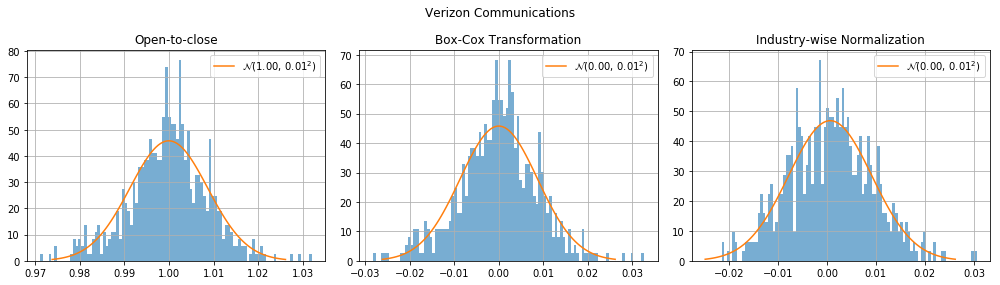

time: 2.78 s


In [646]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot.compare_with_normal(price.otc, 'Open-to-close', ax=axes[0])
plot.compare_with_normal(price.boxcox, 'Box-Cox Transformation', ax=axes[1])
plot.compare_with_normal(price.boxcox - ind_means[securities.get_industry(sym)], 'Industry-wise Normalization', ax=axes[2])
fig.suptitle(securities.get_company_name(sym))
fig.tight_layout()
plt.subplots_adjust(top=0.83)
# fig.savefig(f'data-preprocessing-{sym}.pdf')

regr.compare_distributions(price.otc - 1, price.lret / 100)
regr.compare_distributions(price.boxcox, price.lret / 100)

### Regression Analysis

#### Distribution

In [892]:
# Using all at once (comp_orig_returns.stack()) -> nothing fits
math_utils.inspect_data_distributions(comp_prices.stack(), verbose=True);

norm            p: 0.0000 D: 0.0600
cauchy          p: 0.0000 D: 0.0509
chi             p: 0.0000 D: 0.3886
chi2            p: 0.0000 D: 0.2765
f               p: 0.0000 D: 0.4534
johnsonsb       p: 0.0000 D: 0.0600
laplace         p: 0.0000 D: 0.0198
logistic        p: 0.0000 D: 0.0232
maxwell         p: 0.0000 D: 0.4710
pareto          p: 0.0000 D: 0.5899
t               p: 0.0000 D: 0.0079
uniform         p: 0.0000 D: 0.4434
wald            p: 0.0000 D: 0.4618
time: 2min 1s


In [13]:
steps_pvalues = pd.DataFrame(index=math_utils.cdfs, columns=['returns', 'normed', 'resid'])
steps_pvalues2 = pd.DataFrame(index=math_utils.cdfs, columns=['returns', 'normed', 'resid'])
for col_name, values in zip(steps_pvalues.columns, [comp_orig_returns, comp_prices, comp_resids]):
    pvalues = pd.DataFrame(index=math_utils.cdfs, columns=comp_symbols)
    for sym, comp_price in tqdm(values.iteritems(), total=len(comp_symbols)):
        pvalues[sym] = math_utils.inspect_data_distributions(comp_price)
    steps_pvalues[col_name] = (pvalues > 0.05).sum(axis=1)
    steps_pvalues2[col_name] = (pvalues > 0.5).sum(axis=1)


time: 4.06 s


In [94]:
steps_pvalues
# steps_pvalues2

,returns,normed,resid
norm,330,304,337
cauchy,17,16,11
chi,125,123,169
chi2,78,67,97
f,330,166,155
johnsonsb,340,310,354
laplace,423,417,398
logistic,467,467,467
maxwell,0,0,0
pareto,0,0,0


time: 239 ms


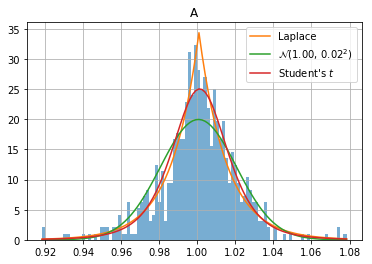

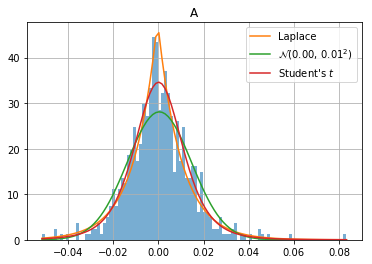

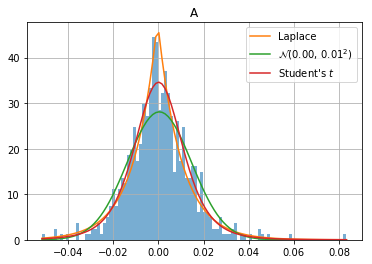

time: 2.11 s


In [10]:
plot.compare(comp_orig_returns['A'])
plot.compare(comp_prices['A'])
plot.compare(comp_resids['A']);

In [ ]:
dfs = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
locs = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
scales = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
for col_name, values in zip(steps_pvalues.columns, [comp_orig_returns, comp_prices, comp_resids]):
    for sym, comp_price in values.iteritems():
        dfs.loc[sym, col_name], locs.loc[sym, col_name], scales.loc[sym, col_name] = stats.t.fit(comp_price)

Average parameters for Student's $t$:

|   -     |         df |          loc |      scale |
|:--------|-----------:|-------------:|-----------:|
| returns |    6.10691 |  1.00038     | 0.0128028  |
| normed  |    6.76845 | -0.000108763 | 0.00890573 |
| resid   |    6.91496 | -0.00554267  | 0.407496   |

For one resid series, the df was 2726813. The outlier was removed for taking the average

#### Characteristics

Test for Unit Root:
>Augmented Dickey-Fuller (null = I(1)): p value = 0.0000
>KPSS (null = I(0)): p value = 0.2056
>Phillips-Perron (null = I(1)): p value = 0.0000

Test for Autocorrelation:
>Durbin-Watson (null(2) = no autocorr., lag 1): statistic = 1.9291
>Ljung-Box-Q (null = no autocorr., lag 1): p value = 0.53

Test for Normal Distribution:
>Jarque-Bera (null = gaussian): p value = 0.0000
>Shapiro-Wilk (null = gaussian): p value = 0.0000
>D’Agostino’s K^2 (null = gaussian): p value = 0.0000
>Anderson-Darling (null = gaussian): p value = 0.0000

Test for Heteroscedastiscity:
>Engle's ARCH (null = homosc.): p value = 0.0022
>White (null = homosc.): p value = 0.0000
>Breusch-Pagan (null = homosc.): p value = 0.0074
>Goldfeld-Quandt (null = homosc.): p value = 0.0000
>Levene alias Brown-Forsythe (null = homosc.): p value = 0.0006
>Fligner-Killeen (null = homosc.): p value = 0.0031
>[DEV]Wald-Test on squares (null = homosc.): p value = 0.3377

Test for Structural Breaks:
>CUSUM test on 

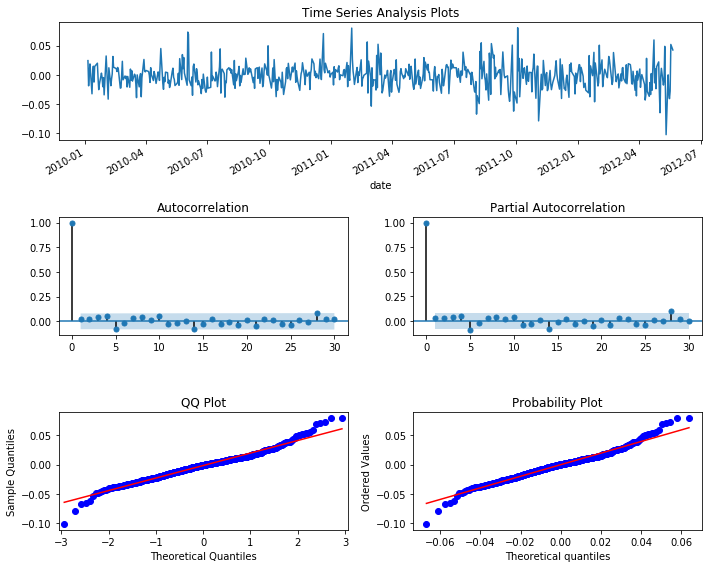

time: 1.63 s


In [108]:
plot.tsplot(price.boxcox);
regr.investigate(price.boxcox, verbose=True);

In [8]:
print(unitroot.ADF(price.boxcox).regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     113.5
Date:                Wed, 03 Apr 2019   Prob (F-statistic):           6.39e-84
Time:                        17:36:03   Log-Likelihood:                 1446.6
No. Observations:                 595   AIC:                            -2881.
Df Residuals:                     589   BIC:                            -2855.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.9317      0.086    -10.797      0.0

#### Seasonality

In [39]:
plot.plot_months(price.boxcox);  # [price.index.year == 2010]

time: 266 ms


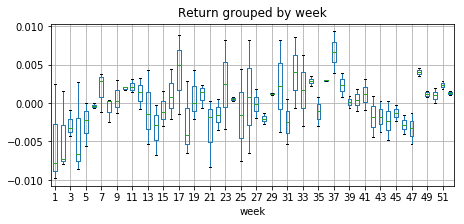

time: 1.29 s


In [662]:
plot.plot_weeks(price.boxcox);

There is no consistent shape over the years for weekdays

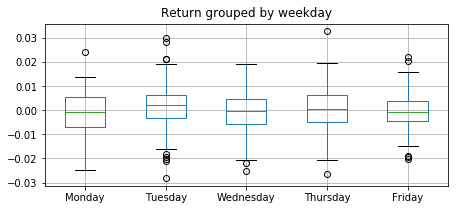

time: 386 ms


In [663]:
plot_weekdays(price.boxcox);

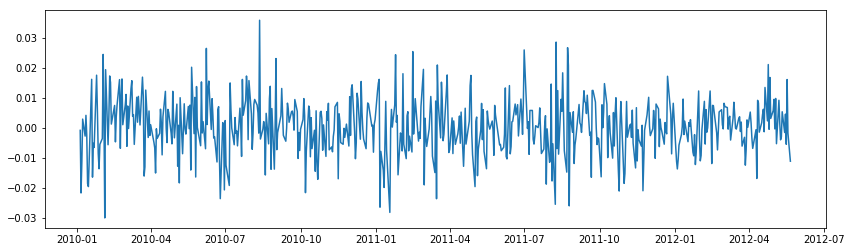

time: 2.94 s


In [486]:
a = smt.SARIMAX(price.boxcox, order=(3, 0, 2), seasonal_order=(0, 1, 1, 12))
f = a.fit(trend='nc', update_freq=5)
plt.subplots(figsize=(14, 4))
plt.plot(f.resid);

- https://medium.com/@a.nejad_99199/exploring-market-seasonality-trends-19a91381c0fe
- https://github.com/anejad/Exploring-Market-Seasonality-Trends/blob/master/Exploring%20Seasonality%20Trends%20in%20Stock%20Market.ipynb
- https://otexts.com/fpp2/components.html
- https://towardsdatascience.com/analysis-of-stock-market-cycles-with-fbprophet-package-in-python-7c36db32ecd0
- https://digitalcommons.wayne.edu/cgi/viewcontent.cgi?article=2030&context=jmasm

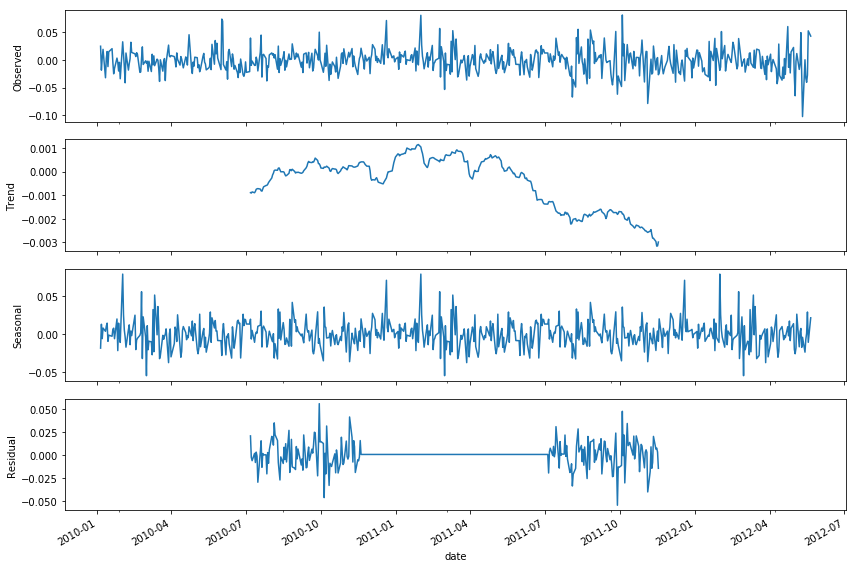

time: 810 ms


In [14]:
regr.inspect_seasonality(price.boxcox);

In [36]:
comps = np.concatenate([list(get_industry(x)) for x in all_industries])  # all_industries[3], all_industries[-2], all_industries
r = pd.concat([price.boxcox - ind_means[securities.get_industry(sym)] for sym, _, price in comps])
symbols = pd.concat([pd.Series([sym]*len(price)) for sym, _, price in comps])
merged = pd.concat([r.reset_index(drop=True), symbols.reset_index(drop=True)], axis=1)
merged.index = r.index
merged.columns = ['return', 'sym']

time: 1.84 s


In [45]:
r = pd.concat([y for x, y in comp_resids.iteritems()])
symbols = pd.concat([pd.Series([x]*len(y)) for x, y in comp_resids.iteritems()])
merged_resids = pd.concat([r.reset_index(drop=True), symbols.reset_index(drop=True)], axis=1)
merged_resids.index = r.index
merged_resids.columns = ['return', 'sym']

time: 297 ms


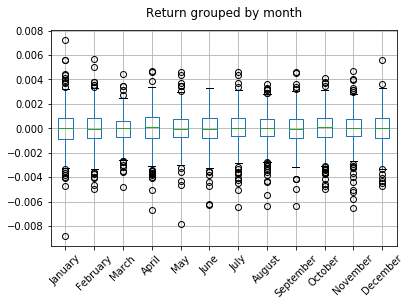

time: 1.24 s


In [43]:
# ry = merged[merged.index.year == 2011]
# plot.plot_weekdays(merged, 'returns-per-weekday.pdf', comp=True);
# plot.plot_weeks(merged, 'returns-per-week.pdf', comp=True);
plot.plot_months(merged, 'returns-per-month.pdf', comp=True);

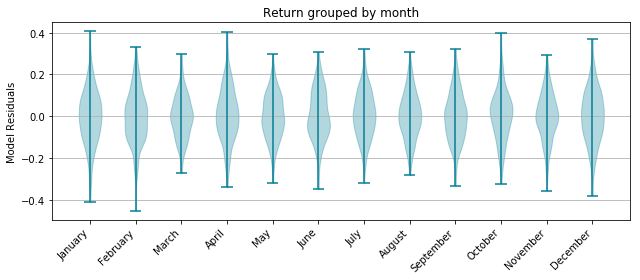

time: 788 ms


In [78]:
plot.plot_months(merged_resids, 'returns-per-month.pdf', comp=True);

In [98]:
pd.DataFrame(
    [x[1].reset_index(drop=True).rename(x[0])
     for x in monthly_returns['return'].groupby(monthly_returns.month)]).std(axis=1)

1     0.126622
2     0.124545
3     0.099797
4     0.126148
5     0.107906
6     0.115013
7     0.110620
8     0.110085
9     0.113705
10    0.117399
11    0.112220
12    0.121319
dtype: float64

time: 218 ms


#### Develop & Fit ARIMA

In [ ]:
# mdl = smt.ARIMA(ts.boxcox, exog=gspc.boxcox[ts.boxcox.index], order=(3, 0, 1)).fit(
#                 method='mle', trend='nc', update_freq=5, disp=0, cov_type='HAC', cov_kwds={'maxlags': 2})
# hac-panel requires grouping

In [ ]:
_, arima_params = regr.get_best_arima(price.boxcox)
model = smt.ARIMA(price.boxcox, order=arima_params)
model_fit = model.fit(method='mle', trend='nc', update_freq=5)
in_sample_predictions = model_fit.predict()

print(model_fit.summary())

In [ ]:
ex_sample_predictions = regr.predict_rolling_forward(price.boxcox, val_price.boxcox, arima_params)

In [ ]:
regr.is_autocorrelated(price.boxcox, verbose=True);
# After ARIMA modelling the autocorrelation is completely gone
regr.is_autocorrelated(model_fit.resid, verbose=True);

In [ ]:
regr.plot_arima_predictions(price.boxcox, val_price.boxcox, arima_params)

#### Develop & fit GARCH

In [ ]:
arima_residuals = regr.ARIMA_GARCH(price.boxcox, *arima_params, 1, 1).arima_fit.resid
_, garch_params = regr.get_best_garch(arima_residuals)
plot.tsplot(arima_residuals**2);

In [ ]:
# Result from last block: PACF is considerable until lag=5
garch_params = (5, 5) # p = lagged variance, q = lagged residuals
model = regr.ARIMA_GARCH(price.boxcox, *arima_params, *garch_params, vol_model='GARCH')
print(model.garch_fit.summary())

In [ ]:
ex_sample_predictions = regr.plot_garch_predictions(price.boxcox, val_price.boxcox, arima_params, garch_params, vol_model='GARCH')

#### Skewness and Kurtosis

-0.06367784742874547 0.059744392761171036
0.6407643610843226 3.0724121010700784


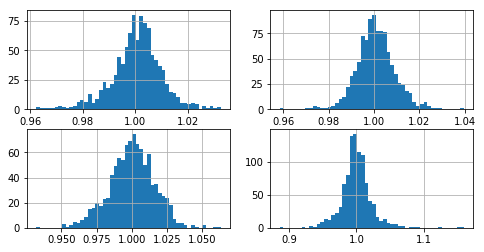

time: 5.48 s


In [130]:
comps = np.concatenate([list(get_industry(x)) for x in all_industries]) 
key = 'otc'
skewness = [smss.robust_skewness(price[key])[-1] for sym, _, price in comps]
orig_skewness = [stats.skew(price[key]) for sym, _, price in comps]
# skewness = [smss.robust_skewness(regr.model_GARCH(regr.model_ARMA(price[key] - ind_means[securities.get_industry(sym)])[0])[0])[-1] for sym, _, price in comps]
print(pd.Series(skewness).mean(), pd.Series(orig_skewness).mean())
kurtosis = [smss.robust_kurtosis(price[key])[-1] for sym, _, price in comps]
orig_kurtosis = [stats.kurtosis(price[key]) for sym, _, price in comps]
# kurtosis = [smss.robust_kurtosis(regr.model_GARCH(regr.model_ARMA(price[key] - ind_means[securities.get_industry(sym)])[0])[0])[-1] for sym, _, price in comps]
print(pd.Series(kurtosis).mean(), pd.Series(orig_kurtosis).mean())
fig, axes = plt.subplots(2, 2, figsize=(8, 4))
comps[np.argmin(skewness)][2][key].hist(bins=50, ax=axes[0, 0])
comps[np.argmax(skewness)][2][key].hist(bins=50, ax=axes[0, 1])
comps[np.argmin(kurtosis)][2][key].hist(bins=50, ax=axes[1, 0])
comps[np.argmax(kurtosis)][2][key].hist(bins=50, ax=axes[1, 1]);

Skewness and Kurtosis of data:
- For ctc   :  skewness =  0.007, kurtosis = 0.811, os = -0.0570, ok =  4.9078
- For oto   :  skewness = -0.404, kurtosis = 0.672, os = -0.0676, ok =  4.2531
- For cto   :  skewness = -0.998, kurtosis = 1.318, os = -0.0610, ok = 14.9623
- For otc   :  skewness = -0.129, kurtosis = 0.590, os =  0.0611, ok =  2.5132
- For boxcox:  skewness = -0.320, kurtosis = 0.586, 
- For normed:  skewness =  1.377, kurtosis = 0.565, os =  0.1114, ok =  3.1895
- For arma  :  skewness =  1.347, kurtosis = 0.563, 
- For garch :  skewness =  0.821, kurtosis = 0.500, os =  0.1088, ok =  2.8641

Much higher kurtosis and different skewness for not-robust estimations (outlier have a big impact).

In [29]:
kurtosis = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
skewness = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
for col_name, values in zip(steps_pvalues.columns, [comp_orig_returns, comp_prices, comp_resids]):
    for sym, comp_price in values.iteritems():
        kurtosis.loc[sym, col_name] = stats.kurtosis(comp_price)
        skewness.loc[sym, col_name] = stats.skew(comp_price)
# print(kurtosis.mean())

time: 3.23 s


#### Inspect Transformations

In [66]:
comps = np.concatenate([list(get_industry(x)) for x in all_industries])
comp_symbols = [x[0] for x in comps]

chars = pd.DataFrame(index=comp_symbols, columns=pd.MultiIndex.from_product(
    [['orig', 'otc', 'boxcox', 'normed', 'resid', 'std_resid'],
     ['unit_root', 'autocorr', 'normal_dist', 'heteroscedastic', 'breaks', 'outliers']]))

models_params = pd.DataFrame(np.nan, columns=['p', 'q', 'r', 's'], index=comp_symbols)

for sym, _, price in tqdm(comps):
    orig, otc, boxcox = price.open, price.otc, price.boxcox
    normed = boxcox - ind_means[securities.get_industry(sym)]
    resid, p, q = regr.model_ARMA(normed)
    std_resid, r, s = regr.model_GARCH(resid)
    
    chars.loc[sym].orig = regr.investigate(orig)
    chars.loc[sym].otc = regr.investigate(otc)
    chars.loc[sym].boxcox = regr.investigate(boxcox)
    chars.loc[sym].normed = regr.investigate(normed)
    models_params.loc[sym] = (p, q, r, s)
    if p != 0 or q != 0:
        chars.loc[sym].resid = regr.investigate(resid)
    if r != 0 or s != 0:
        chars.loc[sym].std_resid = regr.investigate(std_resid)

has_arma_applied = (models_params.p != 0) | (models_params.q != 0)
has_garch_applied = (models_params.r != 0) | (models_params.s != 0)
print('Applied ARMA models:', sum(has_arma_applied))
print('Applied GARCH models:', sum(has_garch_applied))

Applied ARMA models: 82
Applied GARCH models: 295
time: 10min 12s


In [69]:
samples = len(train_comp_prices[0])
expected_outliers = round(samples * 0.005)
print(samples, expected_outliers)

984 5
time: 199 ms


In [152]:
t = chars.T
t.index = t.index.swaplevel()
# ur = t.loc['unit_root']
# ur = t.loc['autocorr']
# ur = t.loc['normal_dist']
# ur = t.loc['heteroscedastic']
# ur = t.loc['breaks']
ur = t.loc['outliers']

ur = ur.fillna(method='ffill')

# Inspect the amount of changes between each transformation step
all_hits = set()
prev = set()
for x in ['orig', 'otc', 'boxcox', 'normed', 'resid', 'std_resid']:  # 
    target = ur # ur.loc[:, has_garch_applied]
    hits = set(target.columns[target.loc[x] > expected_outliers])
#     hits = set(target.columns[target.loc[x] > 0])
    print(len(hits), len(hits - prev), len(prev - hits))
    prev = hits
    all_hits = all_hits.union(prev)

15 15 0
126 122 11
128 40 38
175 115 68
170 2 7
199 60 31
time: 289 ms


In [158]:
t = chars.T
t.index = t.index.swaplevel()
# ur = t.loc['unit_root']
# ur = t.loc['autocorr']
# ur = t.loc['normal_dist']
# ur = t.loc['heteroscedastic']
# ur = t.loc['breaks']
ur = t.loc['outliers']

ur = ur.fillna(method='ffill')

# Inspect the amount of changes between each transformation step
all_hits = set()
prev = set()
for x in ['orig', 'otc', 'boxcox', 'normed', 'resid', 'std_resid']:  # 
    target = ur # ur.loc[:, has_garch_applied]
    hits = set(target.columns[target.loc[x] > 3])
    print(len(hits), len(hits - prev), len(prev - hits))
    prev = hits
    all_hits = all_hits.union(prev)

13 13 0
129 126 10
134 41 36
163 109 80
162 4 5
163 39 38
time: 431 ms


__Unit Root:__
- Orig, 9 without UR: `['HBAN', 'HBI', 'KEY', 'LEG', 'MTB', 'PEG', 'RSG', 'SYY', 'YHOO']`
    - Did not became worse in any step
- OTC didn't work, 8 left with UR: `['FSLR', 'FTR', 'GILD', 'INTC', 'NFLX', 'PFE', 'SIG', 'STX']`
- Box-Cox didn't change anything
- Normed only made it worse, 26: `['ADBE', 'EQIX', 'FE', 'FOX', 'ILMN', 'KMB', 'MON', 'MSFT', 'NFX', 'PCAR', 'RRC', 'SPG', 'UPS', 'V', 'WDC', 'WMT', 'WYNN', 'XOM']`
- ARMA fixed for one company out of eight where it was applied
- GARCH fixed one comp and unfixed one comp (out of 18 applications)

--> Finally 23 stocks still do not satisfy the KPSS test

__Auto Correlation:__
- All are totally auto-correlated
- After OTC all still have at least one significant test result for auto-correlation
- After Box-Cox only 104 still have significance (50x 1.0, 54x 0.5)
- After Normalization only 67 still have significance (39x 1.0, 28x 0.5)
- After ARMA only 2 have significance
- After GARCH only 7 have significance

__Normal Distribution:__
- Initially 35 reveal evidence for norm. (at least 1 out of 4 tests)
- 22 OTC returns indicate norm.
- Box-Cox Transformation adds 8 and removes 2
- Normalization adds 20 and removes 25 (->23). It has a huge impact since it changes the data properties in a drastic way. While the combination of an industrial mean and a stocks individual moves, revealed evidenve for the existence/absence of a norm., it switched after extracting the individual behaviour.
- Taking ARMA residuals and GARCH residuals lead to 18 more normal distributions (ARMA: +-0, GARCH: +19-1) --> Finally 41

__Heteroscedasticity:__
- 386 (122 twice) OTC returns are heteros.
- Box-Cox made it much worse: 429 (303 twice) heteros.
- Normalization fixed many: 243 heteros (75 twice, 155 White over BP, 13 BP over White) heteros.
- After ARMA modelling 240 remain (73 twice)
- After GARCH 125 (25 twice, 81 White over BP, 19 BP over White) stock prices remain which do not satify our test for homoscedasticity

__Structural Breaks:__
- Only 9 of all original prices are assumed to contain at least one structural break
- Before transformation and normalization 6 show evidence, afterwards 12.
- The number does not change much between the steps of transformations except for the normalization step. Eventhough, we are trying to remove the mean movement across one industry, not all prices might contain this overall behaviour for the entire period. Therefore for some periods of stock prices, the normalization step appears to introduce a new movement which leads to the significant rejection of stable coefficients over the entire times series.
- After ARMA & GARCH: 11

##### ACF

In [150]:
lag_acf = pd.DataFrame(columns=np.arange(10), index=comp_prices.columns)
lag_acf_resid = pd.DataFrame(columns=np.arange(10), index=comp_prices.columns)
is_ac = pd.DataFrame(columns=np.arange(10), index=comp_prices.columns)
is_ac_resid = pd.DataFrame(columns=np.arange(10), index=comp_prices.columns)
for sym, ts in tqdm(comp_prices.iteritems()):
    acf_vals, confint = smt.acf(ts, nlags=len(lag_acf.columns), alpha=0.05)
    acf_vals, confint = acf_vals[1:], confint[1:]
    is_ac.loc[sym] = sms.acorr_ljungbox(ts, lags=10)[1] <= 0.05
    lag_acf.loc[sym] = acf_vals
    ts, p, q = regr.model_ARMA(ts)
    if p | q:
        acf_vals, confint = smt.acf(ts, nlags=len(lag_acf.columns), alpha=0.05)
        acf_vals, confint = acf_vals[1:], confint[1:]
        lag_acf_resid.loc[sym] = acf_vals
        is_ac_resid.loc[sym] = sms.acorr_ljungbox(ts, lags=10)[1] <= 0.05

# lag_acf[~(lag_acf == lag_acf_resid).all(axis=1)].shape
print("AC before:", is_ac[is_ac.any(axis=1)].shape[0])
print("ARMA, AC before:", is_ac[is_ac_resid.notna().any(axis=1)].shape[0])
print("ARMA applied:", is_ac_resid[is_ac_resid.notna().any(axis=1)].shape[0])
print("Still AC after modelling:", is_ac_resid[is_ac_resid.any(axis=1)].shape[0])

print("\nONLY FIRST LAG:")
# lag_acf[~(lag_acf == lag_acf_resid).all(axis=1)].shape
print("AC before:", is_ac[is_ac[0]].shape[0])
print("ARMA, AC before:", is_ac[is_ac_resid.notna()[0]].shape[0])
print("ARMA applied:", is_ac_resid[is_ac_resid.notna()[0]].shape[0])
print("Still AC after modelling:", is_ac_resid[is_ac_resid[0].fillna(False)].shape[0])

AC before: 161
ARMA, AC before: 66
ARMA applied: 66
Still AC after modelling: 4

ONLY FIRST LAG:
AC before: 66
ARMA, AC before: 66
ARMA applied: 66
Still AC after modelling: 1
time: 316 ms


##### Outliers

In [93]:
dfs = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
locs = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
scales = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
for col_name, values in zip(steps_pvalues.columns, [comp_orig_returns, comp_prices, comp_resids]):
    for sym, comp_price in valu<es.iteritems():
        dfs.loc[sym, col_name], locs.loc[sym, col_name], scales.loc[sym, col_name] = stats.t.fit(comp_price)

time: 55.5 s


Average parameters for Student's $t$:

|   -     |         df |          loc |      scale |
|:--------|-----------:|-------------:|-----------:|
| returns |    6.10691 |  1.00038     | 0.0128028  |
| normed  |    6.76845 | -0.000108763 | 0.00890573 |
| resid   |    6.91496 | -0.00554267  | 0.407496   |

For one resid series, the df was 2726813. The outlier was removed for taking the average

In [635]:
outliers = []

for sym, _, price in tqdm(comps):
    orig, otc, boxcox = price.open, price.otc, price.boxcox
    normed = boxcox - ind_means[securities.get_industry(sym)]
    outliers.append(normed.iloc[regr.get_outliers(normed)])
    
outliers = pd.concat([x.reset_index(drop=True) for x in outliers], axis=1)

time: 25.6 s


Expected outliers: 4.92 (vs. 7)


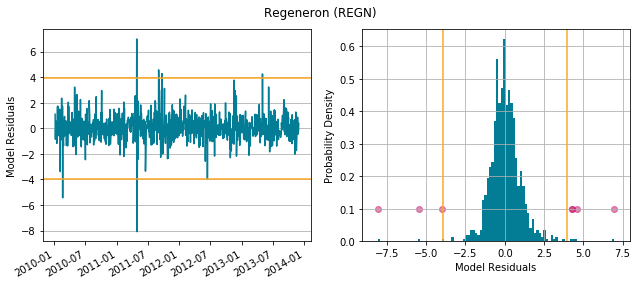

time: 1.04 s


In [109]:
# sym, name, price = comps[outliers.max().idxmax()]
# sym, name, price = comps[(outliers.notna().sum() == outliers.shape[0]).idxmax()]
# price = price.boxcox - ind_means[securities.get_industry(sym)]
sym = 'REGN'
name, price = securities.get_company_name(sym), comp_resids[sym]
regr.get_outliers(price, debug=True);
fig = plt.gcf()
fig.suptitle(f'{name} ({sym})')
fig.tight_layout()
plt.subplots_adjust(top=0.9)
# fig.savefig(f'data-outliers-{sym}.pdf')

KS-test result: Best result for Student's t with 0.84 and only 0.16 for norm.

- https://finance.yahoo.com/quote/REGN/history?period1=1303250400&period2=1304200800&interval=1d&filter=history&frequency=1d
- https://newsroom.regeneron.com/news-releases/news-release-details/regeneron-and-bayer-report-positive-results-vegf-trap-eye-second/
- https://newsroom.regeneron.com/node/18236/html
- https://investor.regeneron.com/financial-information?field_nir_sec_form_group_target_id%5B476%5D=476&field_nir_sec_date_filed_value=2011&items_per_page=10&page=2
- Bloomberg Articles: 203653, 204912

##### Compare HET tests

In [319]:
het_stats = pd.DataFrame(index=comp_symbols, columns=['white', 'bp'])
het_stats2 = pd.DataFrame(index=comp_symbols, columns=['white', 'bp'])
for sym, _, price in tqdm(comps):
    orig, otc, boxcox = price.open, price.otc, price.boxcox
    normed = boxcox - ind_means[securities.get_industry(sym)]
    resid, p, q = regr.model_ARMA(normed)
    std_resid, r, s = regr.model_GARCH(resid)
    ts, exog = regr.get_auto_lags(normed)
    het_stats.loc[sym] = sms.het_white(ts, exog)[1] <= 0.05, sms.het_breuschpagan(ts, exog)[1] <= 0.05
    ts, exog = regr.get_auto_lags(std_resid)
    het_stats2.loc[sym] = sms.het_white(ts, exog)[1] <= 0.05, sms.het_breuschpagan(ts, exog)[1] <= 0.050


time: 1min 55s


### Correlate Industry-wise

#### Setup

In [ ]:
def calc_residuals_v2(industries=all_industries, norm_gspc=False, val=False):
    comps = np.concatenate([list(get_industry(x, val=val)) for x in industries]) 
    comp_symbols = [x[0] for x in comps]
    comp_chars = pd.DataFrame(
        index=comp_symbols, columns=[
        'p', 'q', 'r', 's', 'unit_root', 'autocorr', 'normal_dist', 'heteroscedastic', 'breaks', 'outliers'])
    comp_resid_chars = comp_chars.copy()
    comp_orig_prices = pd.DataFrame([x[2].open.rename(x[0]) for x in comps]).T
    comp_orig_returns = pd.DataFrame([x[2].otc.rename(x[0]) for x in comps]).T
    if norm_gspc:
        comp_prices = pd.DataFrame([(x[2].boxcox - gspc.boxcox[x[2].index]).rename(x[0]) for x in comps], index=comp_symbols).T
    else:
        temp_ind_means = ind_means_val if val else ind_means
        comp_prices = pd.DataFrame([(x[2].boxcox - temp_ind_means[securities.get_industry(x[0])]).rename(x[0]) for x in comps], index=comp_symbols).T
    comp_resids = pd.DataFrame(index=comp_prices.index, columns=comp_symbols)
    
    # Apply ARIMA and take residuals
    for symbol, comp_name, _ in tqdm(comps):
        comp_price = comp_prices[symbol].copy()
        resid, p, q = regr.model_ARMA(comp_price)
        std_resid, r, s = regr.model_GARCH(resid)
        comp_resids.loc[:, symbol] = std_resid
        comp_chars.loc[symbol] = (p, q, r, s, *regr.investigate(comp_price))
        comp_resid_chars.loc[symbol] = (p, q, r, s, *regr.investigate(std_resid))
        time.sleep(0.5)
    
    print('Are the characteristics the same as before?', (comp_resid_chars == comp_chars).all().all())
    return comp_symbols, comp_resids, comp_prices, comp_orig_returns, comp_orig_prices, comp_resid_chars

#### Correlations vs GSPC

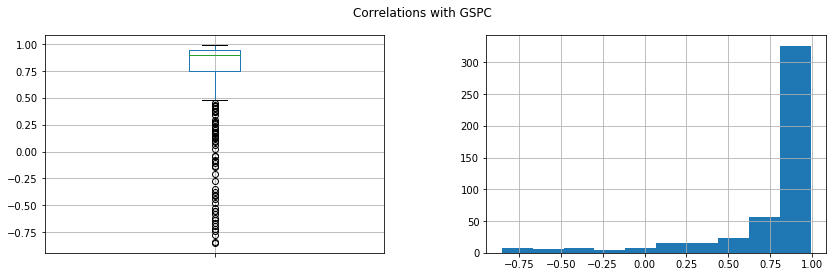

time: 590 ms


In [29]:
gspc_corrs = pd.DataFrame([math_utils.correlation(gspc.open[:len(x)], x.open)
                           for x in train_comp_prices], index=comp_metas.symbol, columns=[''])
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
gspc_corrs.boxplot(ax=axes[0])
gspc_corrs.hist(ax=axes[1])
fig.suptitle('Correlations with GSPC');

#### Correlation within Industry

In [32]:
ind_symbols, ind_resids, ind_prices, ind_orig_returns, ind_orig_prices, ind_resid_chars = calc_residuals_v2(['Energy'])


Are the characteristics the same as before? True
time: 51.2 s


In [33]:
ind_resid_chars.head()

,p,q,r,s,unit_root,autocorr,normal_dist,heteroscedastic,breaks,outliers
APA,1,1,2,5,0,0,0,0,0,12
APC,1,1,1,1,0,0,0,0,0,11
BHI,0,0,1,1,0,0,0,0,0,6
CHK,3,2,4,10,0,0,0,0.5,0,9
COG,0,0,1,2,0,0,0,0,0,11


time: 216 ms


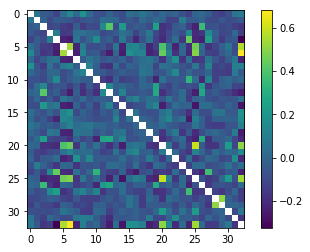

time: 874 ms


In [12]:
energy_correlations = regr.calc_correlations(ind_symbols, ind_resids)
plt.imshow(energy_correlations)
plt.colorbar();

Correlate CVX and XOM:
Pearson's r = 0.68 (without preprocessing: 0.95)
Correlate COG and XOM:
Pearson's r = -0.32 (without preprocessing: 0.72)


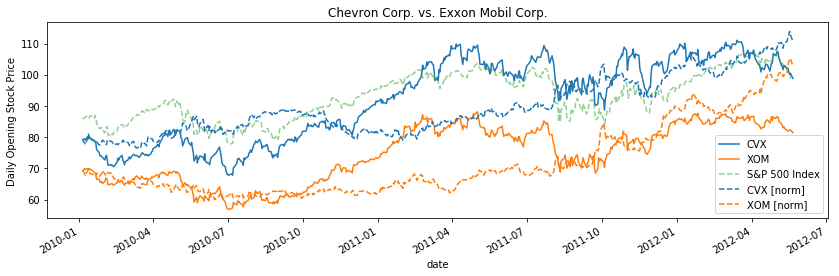

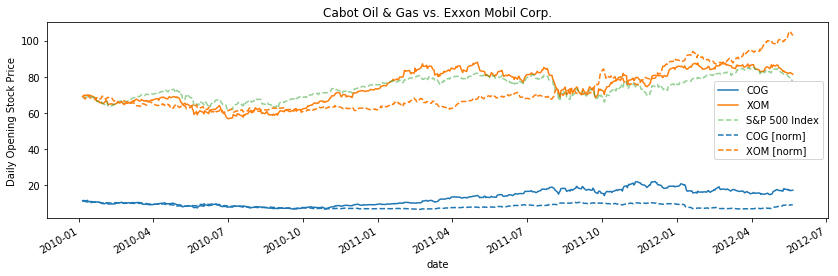

time: 1.39 s


In [497]:
stack = energy_correlations.stack()
pair = stack.idxmax()
# price_resids
plot.compare_industry_players(pair, energy_correlations.loc[pair], ind_prices, ind_orig_prices, gspc.open, securities)

pair = stack.idxmin()
plot.compare_industry_players(pair, energy_correlations.loc[pair], ind_prices, ind_orig_prices, gspc.open, securities)

Final correlation:  0.6922867603318198


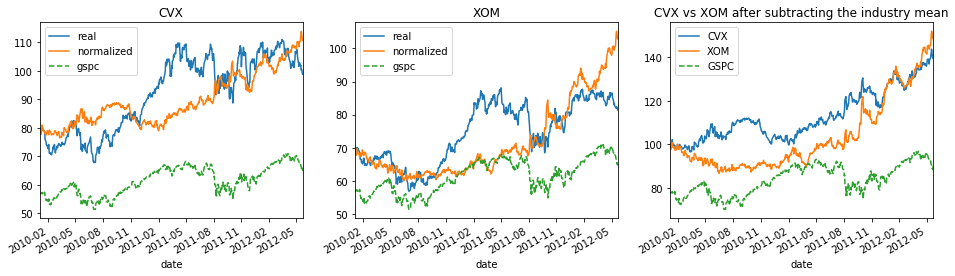

time: 1.34 s


In [499]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
a, b = stack.idxmax()
ind_orig_prices[a].plot(ax=axes[0], label='real', legend=True)
math_utils.abs_values(ind_prices[a], ind_orig_prices[a][0]).plot(ax=axes[0], label='normalized', legend=True, title=a)
(gspc.open / 20).plot(ls='--', ax=axes[0], label='gspc', legend=True)
axes[0].set_xlim((ind_prices[a].index[0], ind_prices[a].index[-1]))

ind_orig_prices[b].plot(ax=axes[1], label='real', legend=True)
math_utils.abs_values(ind_prices[b], ind_orig_prices[b][0]).plot(ax=axes[1], label='normalized', legend=True, title=b)
(gspc.open / 20).plot(ls='--', ax=axes[1], label='gspc', legend=True)
axes[1].set_xlim((ind_prices[b].index[0], ind_prices[b].index[-1]))

x = math_utils.abs_values(ind_prices[a])
y = math_utils.abs_values(ind_prices[b])
pd.concat([x, y], axis=1).plot(ax=axes[2], title=f'{a} vs {b} after subtracting the industry mean')
(gspc.open / gspc.open.max() * 100).plot(ls='--', ax=axes[2], label='GSPC', legend=True)
axes[2].set_xlim((x.index[0], x.index[-1]))
print('Final correlation: ', math_utils.correlation(*ind_prices.loc[:, stack.idxmax()].T.values))

#### Impact of Exogeneous Variables

Instead of subtracting the GSPC movement, one may consider GSPC (and industry mean) as exogeneous variables during the autoregression. The AR residuals (orange line) show that many GSPC movements almost vanished.

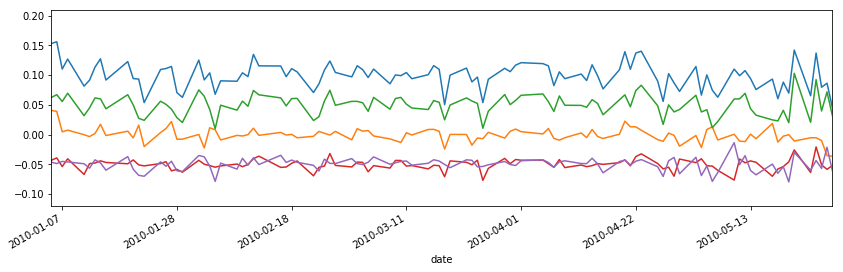

time: 519 ms


In [103]:
a, b = stack.idxmax()
ts = train_comp_prices[(comp_metas.symbol == a).idxmax()].boxcox  # industry_prices.loc[:, a]

mdl = smt.ARIMA(ts, exog=exog, order=(2, 0, 1)).fit(method='mle', trend='nc')

(ts + 0.1).plot(figsize=(14, 4))
plt.plot(mdl.resid)
plt.plot(mdl.fittedvalues + 0.05)
plt.plot(exog - 0.05)
plt.xlim((ts.index[0], ts.index[100]));

In [23]:
aic_values = regr.get_best_arima(ts, p=range(20), q=range(3, 4), exog=exog, debug=True)

Best AIC: -3844.2186 (worst: -3856.1580) | params: 19, 0, 3
time: 42min 20s


In [72]:
regr.investigate(mdl.resid, verbose=True);

Test for Unit Root:
>Augmented Dickey-Fuller (null = I(1)): p value = 0.0000
>KPSS (null = I(0)): p value = 0.7918
>Phillips-Perron (null = I(1)): p value = 0.0000

Test for Autocorrelation:
>Durbin-Watson (null(2) = no autocorr., lag 1): statistic = 1.8500
>Ljung-Box-Q (null = no autocorr., lag 1): p value = 0.09

Test for Normal Distribution:
>Jarque-Bera (null = gaussian): p value = 0.0000
>Shapiro-Wilk (null = gaussian): p value = 0.0000
>D’Agostino’s K^2 (null = gaussian): p value = 0.0000
>Anderson-Darling (null = gaussian): p value = 0.0000

Test for Heteroscedastiscity:
>Engle's ARCH (null = homosc.): p value = 0.0000

Test for Structural Breaks:
>CUSUM test on OLS residuals (null = stable coeff): p value = 0.9110
time: 310 ms


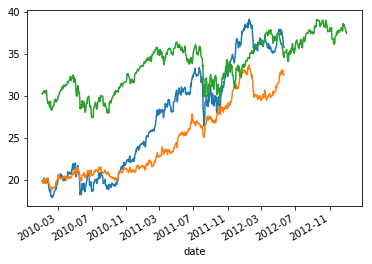

time: 487 ms


In [126]:
x.plot()
math_utils.abs_values(mdl.resid, x.iloc[0]).plot()
plt.plot(gspc.open / gspc.open.max() * x.max());

Outcome: I takes very long and the differences between the models are very small. So we keep the amount of coefficients low. Note that the significance is not present for less coeff.

#### Industry vs GSPC

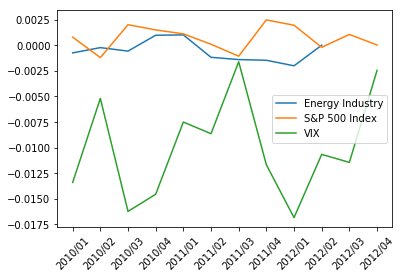

time: 502 ms


In [232]:
plot.plot_performance_quarterly(ind_prices, label='Energy Industry')
plot.plot_performance_quarterly(gspc.boxcox, label='S&P 500 Index')
plot.plot_performance_quarterly(vix.boxcox, label='VIX')
plt.legend();

### Graph

#### Setup

In [4]:
# https://github.com/ucsd-ccbb/visJS2jupyter/blob/master/visJS2jupyter/visJS_module.py
# http://compbio.ucsd.edu/bringing-interactivity-network-visualization-jupyter-notebooks-visjs2jupyter/
def display_interactive_graph(G, output_file=None, pos=None, weight_threshold=0.5, title='correlation', layout_params={}, **kwargs):
    # Prepare graph data
    V = list(G.nodes())
    E = list(G.edges())
    weights = [x['weight'] for x in G.edges().values()]
    # To avoid subgraphs from drifting away: https://stackoverflow.com/a/54876985/4816930
    pos = (pos or nx.spring_layout)(G, **layout_params)

    V_enriched = [(x, securities.get_company_name(x), securities.get_industry(x), fundamentals.get_revenue(x)) for x in V]
    colors = plot.get_colors(np.unique([x[2] for x in V_enriched]))
    revenue_mean = np.nanmean([x[3] for x in V_enriched])
    revenue_max = np.nanmax([x[3] for x in V_enriched])

    nodes_dict = [{"id":n,
                   "title": f'{comp} ({industry})',
                   "color": colors[industry],
                   "border_width": 0.3,
                   "degree": ((revenue if not np.isnan(revenue) else revenue_mean) / revenue_max)**0.4 * 25,
                   "x":pos[n][0]*200,
                   "y":pos[n][1]*200} for (n, comp, industry, revenue) in V_enriched]
    node_map = dict(zip(V, range(len(V))))
    edges_dict = [{"id": f'{weights[i]:.2f}', "source": node_map[E[i][0]], "target": node_map[E[i][1]],
                   "dashes": ([15, 15] if weights[i] < 0 else False), "width": 6 * np.abs(weights[i])**2
                  } for i in range(len(E))]  #  if weights[i] > weight_threshold
    return visJS_module.visjs_network(nodes_dict, edges_dict, graph_id=title, container=f'mynetwork{title}', node_icon_code="'undefined'",
                                      edge_width_field='width', edge_label_field='none', node_size_multiplier=2, node_font_size=8,
                                      graph_height=400, graph_width=800, export_network=bool(output_file), export_file=output_file, **kwargs)

def generate_graph(edges):
    edges = [(idx[0], idx[1], { 'weight': val }) for idx, val in edges.iteritems()]
    G = nx.Graph(title='number_of_shared_articles')
    G.add_weighted_edges_from([(x[0], x[1], x[2]['weight']) for x in edges])
    return G

def display_correlation_graph(correlations, pos=None, threshold=0.5, debug=False, **kwargs):
    # Create and display grap
    if len(correlations.shape) == 2:
        edges = correlations.stack()
    else:
        edges = correlations
    edges = edges[edges.abs() >= threshold]
#     nodes = list(edges[edges >= threshold].index.remove_unused_levels().levels[0])
#     edges = correlations.loc[nodes, nodes].stack()
#     edges = edges[edges >= 0.2]
    G = generate_graph(edges)
    if debug:
        print(f"Threshold: {threshold:.2f}")
        print(f"Edges: {len(G.edges())}")
        print(f"Nodes: {len(G.nodes())}")
    return display_interactive_graph(G, pos=pos, weight_threshold=threshold, **kwargs)

time: 406 ms


#### Generate for one industry

In [ ]:
display_correlation_graph(energy_correlations)

#### Generate for multiple industries

In [708]:
comp_symbols, comp_resids, comp_prices, comp_orig_returns, comp_orig_prices, comp_resid_chars = calc_residuals_v2(
    [all_industries[3], *all_industries[-2:]])

Are the characteristics the same as before? True
time: 1min 52s


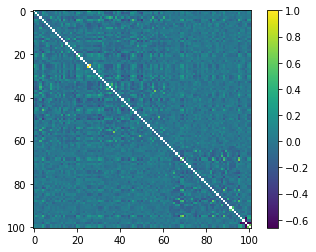

time: 8.83 s


In [709]:
correlations = calc_correlations(comp_symbols, comp_resids)
plt.imshow(correlations)
plt.colorbar();

In [ ]:
# Layouts: https://networkx.github.io/documentation/networkx-2.2/reference/drawing.html
display_correlation_graph(correlations, threshold=np.percentile(correlations.stack(), 99),
                          layout_params={'k': 0.3, 'iterations': 100, 'seed': 42})

#### All Companies

In [ ]:
comp_symbols, comp_resids, comp_prices, comp_orig_returns, comp_orig_prices, comp_resid_chars = calc_residuals_v2(all_industries)
model_params = comp_resid_chars[['p', 'q', 'r', 's']]

In [86]:
all_correlations = regr.calc_all_correlations(comp_symbols, comp_resids, comp_prices, comp_orig_returns, comp_orig_prices)

time: 9min 15s


In [ ]:
# coor residuals - 99.9 Percentile: 0.3654, 109 edges, 121 nodes
# After considering neg: 0.3688, 109 edges (incl. 4 neg.), 123 nodes, 11 industries, only 6 diff-industry edges
display_correlation_graph(all_correlations.Residuals, threshold=np.percentile(all_correlations.Residuals.abs(), 99.9),
                          layout_params={'k': 0.7, 'iterations': 250, 'seed': 42}, scaling_factor=1)
                          # output_file='graph-corr-resid-999-42')

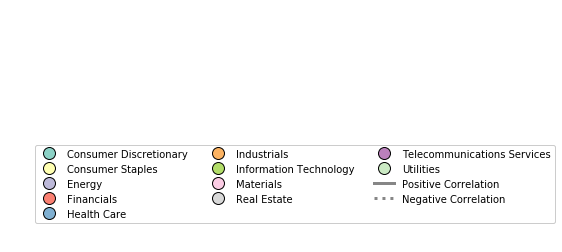

time: 594 ms


In [596]:
industry_colors = {'Consumer Discretionary': 'rgb(141, 211, 199)', 'Consumer Staples': 'rgb(256, 256, 179)', 'Energy': 'rgb(190, 186, 218)', 'Financials': 'rgb(251, 128, 114)', 'Health Care': 'rgb(128, 177, 211)', 'Industrials': 'rgb(253, 180, 98)', 'Information Technology': 'rgb(179, 222, 105)', 'Materials': 'rgb(252, 205, 229)', 'Real Estate': 'rgb(217, 217, 217)', 'Telecommunications Services': 'rgb(188, 128, 189)', 'Utilities': 'rgb(204, 235, 197)'}
industry_colors = plot.get_colors(industry_colors.keys(), as_string=False)

colors = [x / 256 for x in industry_colors.values()]  # ["crimson", "purple", "gold"]
# f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
# handles = [f("o", colors[i]) for i in range(len(colors))]
handles = [plt.Line2D([], [], linewidth=0, marker='o', markersize=12, markeredgecolor='black', markerfacecolor=colors[i]) for i in range(len(colors))]
handles.append(plt.Line2D([], [], linewidth=3, color='#868686'))
handles.append(plt.Line2D([], [], linewidth=3, linestyle=':', color='#868686'))
labels = list(industry_colors.keys())
labels.append('Positive Correlation')
labels.append('Negative Correlation')
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=True, ncol=3)  # , title="Industry Sectors")

def export_legend(legend, filename="legend.pdf", expand=[-4,-4,4,4]):
    plt.axis('off')
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

##### Inspect all_correlations

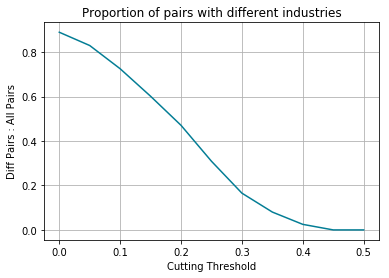

time: 942 ms


In [519]:
ratios = []
for threshold in np.arange(0, 0.55, 0.05):
    within = all_correlations.Residuals[all_correlations.Residuals.abs() >= threshold]
    without = all_correlations.Residuals[[sym2industry[x] != sym2industry[y] for x, y in all_correlations.index]]
    without = without[without.abs() >= threshold]
    ratios.append(len(without) / len(within))
    # print(threshold, len(without), len(within), len(without) / len(within))
plt.plot(np.arange(0, 0.55, 0.05), ratios, color=plot.primary)
plt.xlabel('Cutting Threshold')
plt.ylabel('Diff Pairs : All Pairs')
plt.title('Proportion of pairs with different industries')
plt.grid();
# plt.gcf().savefig('diff-industry-pairs-proportion.pdf')

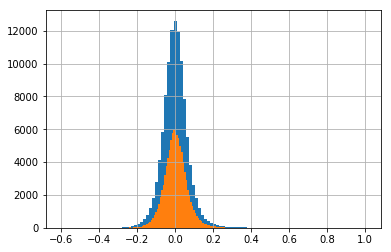

time: 1.39 s


In [493]:
sym2industry = dict([(sym, securities.get_industry(sym)) for sym in comp_symbols])
all_correlations.Residuals.hist(bins=100);
all_correlations.Residuals[[sym2industry[x] != sym2industry[y] for x, y in all_correlations.index]].hist(bins=100);

In [627]:
industrywise_corr = all_correlations.Residuals[[sym2industry[x] == sym2industry[y] for x, y in all_correlations.index]]
grouped = industrywise_corr.groupby([sym2industry[x] for x, _ in industrywise_corr.index])
grouped.mean()

Consumer Discretionary        -0.010571
Consumer Staples              -0.022773
Energy                        -0.026772
Financials                    -0.014589
Health Care                   -0.014548
Industrials                   -0.007268
Information Technology        -0.010054
Materials                     -0.037657
Real Estate                   -0.027086
Telecommunications Services   -0.142416
Utilities                     -0.029256
Name: Residuals, dtype: float64

time: 271 ms


In [473]:
z = all_correlations.Residuals.abs()
percentile = np.percentile(z, 99.9)
z = z[z > percentile]
z.index = z.index.remove_unused_levels()
percentile, sum([securities.get_industry(x) != securities.get_industry(y) for x, y in z.index])

(0.3687916396807692, 6)

time: 491 ms


##### Compare with text-based grah

In [467]:
x = pairwise_dist[pairwise_dist / 2 >= np.percentile(pairwise_dist / 2, 99.9)].dropna()
y = all_correlations.Residuals.abs()[all_correlations.Residuals.abs() >= np.percentile(all_correlations.Residuals.abs(), 99.9)]
x[x.index.isin(y.index)]

,,0.1
A,AAL,
AET,HUM,1.620339
BAC,C,1.249804
GD,LMT,1.115188
MRK,PFE,1.115085


time: 368 ms


##### Inspect model params
And plot showcases for ARMA and GARCH

     p    q    r    s
0  401  401  239  239
1   59   59  178  160
2    6    7   33   42
3    1    0   16   18
4    0    0    1    2
5    0    0    0    3
6    0    0    0    2
8    0    0    0    1


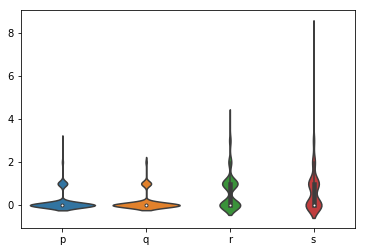

time: 409 ms


In [399]:
print(pd.concat([
    model_params.groupby('p').count().iloc[:, 0].rename('p'),
    model_params.groupby('q').count().iloc[:, 0].rename('q'),
    model_params.groupby('r').count().iloc[:, 0].rename('r'),
    model_params.groupby('s').count().iloc[:, 0].rename('s'),
], axis=1).fillna(0).astype(int))
sns.violinplot(data=model_params);

##### ACF - Show Case

In [100]:
x = model_params
x = x[(x.p > 0) & (x.q > 0) & (x.p != x.q)]
x = x.loc[x.median(axis=1).nlargest(10).index]
x

,p,q,r,s
SIG,3,2,1,2
APC,3,1,1,8
AWK,2,1,1,1
IFF,3,2,0,0


time: 299 ms


In [123]:
sym = 'AWK'  # model_params[model_params.s == 8].index[0]
resid = regr.model_ARMA(comp_prices[sym])[0]
std_resid = regr.model_GARCH(resid)[0]

time: 798 ms


p    2
q    1
r    1
s    1
Name: AWK, dtype: object


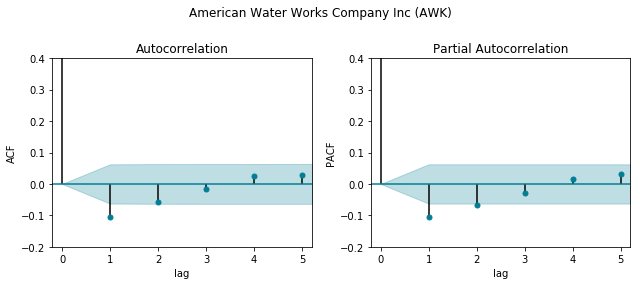

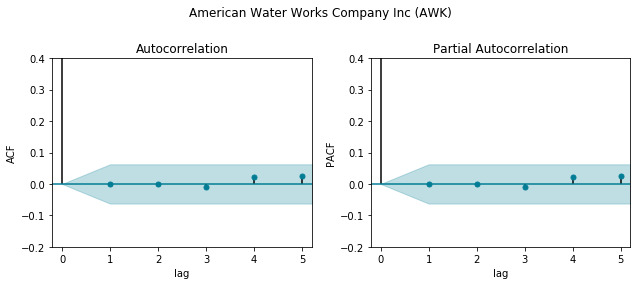

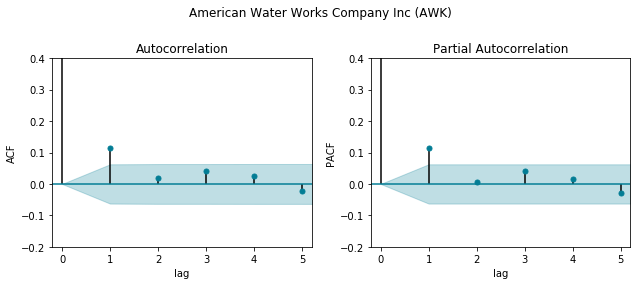

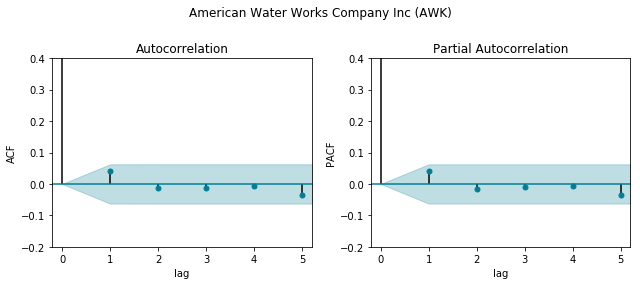

time: 2.98 s


In [246]:
sym = 'AWK'  #  model_params[model_params.p == 3].index[0]  # 'NFX' 
# sym = model_params[model_params.s == 8].index[0]
print(model_params.loc[sym])

fig, axes = plot.plot_acf_pacf(comp_prices[sym], sym, securities, 10)
fig.savefig(f'acf-{sym.lower()}-normed.pdf')

resid = regr.model_ARMA(comp_prices[sym])[0]
fig, axes = plot.plot_acf_pacf(resid, sym, securities, 10)
fig.savefig(f'acf-{sym.lower()}-resid.pdf')

fig, axes = plot.plot_acf_pacf(resid**2, sym, securities, 10)
fig.savefig(f'acf-{sym.lower()}-resid-sqr.pdf')

std_resid = regr.model_GARCH(resid)[0]
fig, axes = plot.plot_acf_pacf(std_resid**2, sym, securities, 10)
fig.savefig(f'acf-{sym.lower()}-std-resid-sqr.pdf')

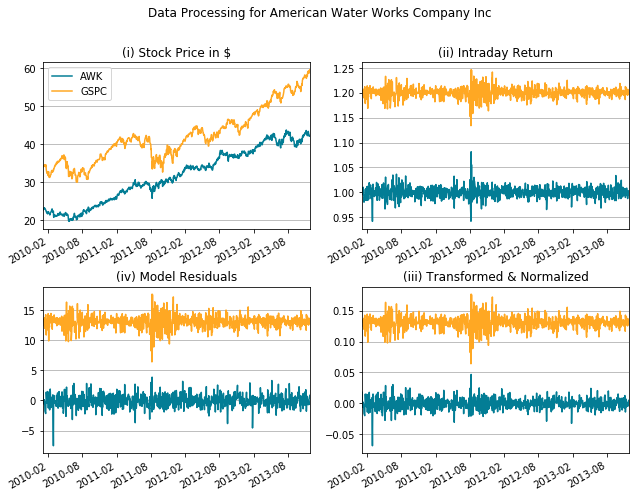

time: 1.18 s


In [193]:
fig, axes = plt.subplots(2, 2, figsize=(9, 7))
axes = [axes[0, 0], axes[0, 1], axes[1, 1], axes[1, 0]]

comp_orig_prices[sym].plot(ax=axes[0], color=plot.primary, title='(i) Stock Price in $', label=sym)
vmin, vmax = comp_orig_prices[sym].min().min(), comp_orig_prices[sym].max().max()
temp_gspc = gspc.open[std_resid.index]
gmin, gmax = temp_gspc.min(), temp_gspc.max()
axes[0].plot(30 + (temp_gspc - gmin) / (gmax - gmin) * vmin * 1.5, label='GSPC', color=plot.secondary)
axes[0].set_xlabel('')
axes[0].set_xlim((temp_gspc.index.min(), temp_gspc.index.max()))
axes[0].legend()
axes[0].yaxis.grid()

comp_orig_returns[sym].plot(ax=axes[1], color=plot.primary, title='(ii) Intraday Return', label=sym)
axes[1].plot(gspc.otc[std_resid.index] + 0.2, label='GSPC', color=plot.secondary)
axes[1].set_xlabel('')
axes[1].set_xlim((temp_gspc.index.min(), temp_gspc.index.max()))
axes[1].yaxis.grid()

comp_prices[sym].plot(ax=axes[2], color=plot.primary, title='(iii) Transformed & Normalized', label=sym)
axes[2].plot(gspc.otc[std_resid.index] - 0.87, label='GSPC', color=plot.secondary)
axes[2].set_xlabel('')
axes[2].set_xlim((temp_gspc.index.min(), temp_gspc.index.max()))
axes[2].yaxis.grid()

std_resid.plot(ax=axes[3], color=plot.primary, title='(iv) Model Residuals', label=sym)
axes[3].plot((gspc.otc[std_resid.index] - 1) * 100 + 13, label='GSPC', color=plot.secondary)
axes[3].set_xlabel('')
axes[3].set_xlim((temp_gspc.index.min(), temp_gspc.index.max()))
axes[3].yaxis.grid()

fig.suptitle(f'Data Processing for {securities.get_company_name(sym)}')
fig.tight_layout()
plt.subplots_adjust(top=0.87)

fig.savefig('data-processing-awk.pdf')

##### Replot AWK Steps for Slides

In [213]:
symbol = 'AWK'
comp_orig_price = train_comp_prices[comp_metas.index[comp_metas.symbol == symbol][0]].open
comp_return = train_comp_prices[comp_metas.index[comp_metas.symbol == symbol][0]].otc
comp_price = train_comp_prices[comp_metas.index[comp_metas.symbol == symbol][0]].boxcox
comp_norm = (comp_price - ind_means[industry_name]).copy()
resid, p, q = regr.model_ARMA(comp_norm)
std_resid, r, s = regr.model_GARCH(resid)
print(p, q, r, s, *regr.investigate(comp_norm))
print(p, q, r, s, *regr.investigate(std_resid))

2 1 1 1 0.0 1.0 0.0 0.5 0.0 2.0
2 1 1 1 0.0 0.0 0.0 0.0 0.0 5.0
time: 1.28 s


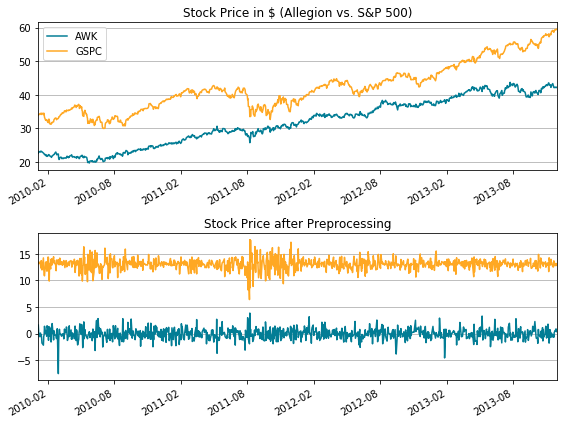

time: 1.28 s


In [64]:
# fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig, axes = plt.subplots(2, figsize=(8, 6))

comp_orig_price.plot(ax=axes[0], color=plot.primary, title=f'Stock Price in $ ({securities.get_company_name(sym)} vs. S&P 500)', label=symbol)
vmin, vmax = comp_orig_price.min().min(), comp_orig_price.max().max()
temp_gspc = gspc.open[std_resid.index]
gmin, gmax = temp_gspc.min(), temp_gspc.max()
axes[0].plot(30 + (temp_gspc - gmin) / (gmax - gmin) * vmin * 1.5, label='GSPC', color=plot.secondary)
axes[0].set_xlabel('')
axes[0].set_xlim((temp_gspc.index.min(), temp_gspc.index.max()))
axes[0].legend()
axes[0].yaxis.grid()

std_resid.plot(ax=axes[1], color=plot.primary, title='Stock Price after Preprocessing', label=sym)
axes[1].plot((gspc.otc[std_resid.index] - 1) * 100 + 13, label='GSPC', color=plot.secondary)
axes[1].set_xlabel('')
axes[1].set_xlim((temp_gspc.index.min(), temp_gspc.index.max()))
axes[1].yaxis.grid()

# fig.suptitle(f'Data Processing for {securities.get_company_name(sym)}')
fig.tight_layout()
# plt.subplots_adjust(top=0.87)

fig.savefig('data-processing-awk-before-after.pdf')

20.31,  19.96, -0.02
20.02,  20.08, 0.00
20.15,  21.77, 0.07
21.81,  21.11, -0.03
21.02,  20.18, -0.04
20.27,  21.34, 0.05


Text(0,0.5,'Stock Price in $')

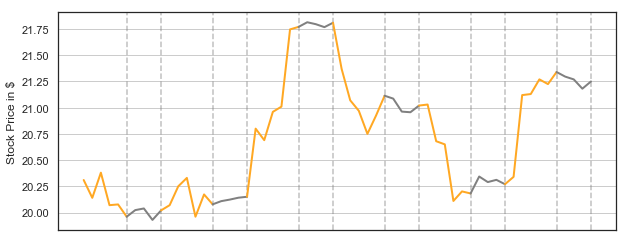

time: 622 ms


In [430]:
selected_period = comp_price.index[
    (comp_price.index >= pd.to_datetime("2010-06-01")) &
    (comp_price.index <= pd.to_datetime("2010-07-13"))]
data = list(comp_orig_price[selected_period].copy().values)
np.random.seed(42)

# ax = ((gspc.boxcox[selected_period] + 0.05)).plot(color=plot.secondary, figsize=(10, 4))
# ax = (ind_means[industry_name][selected_period] - 0.07).plot(color=plot.secondary, figsize=(10, 4))
# for x, y in reversed(list(zip(selected_period[::5], [*selected_period[5::5], selected_period[-1]]))):
for x in list(range(len(data)))[:1:-5]:
    overnight_values = (np.random.random(5) - 0.5) / 5 + data[x]
    data = [*data[:x], *overnight_values, *data[x:]]
ax = plot.plot_multicolored_lines(np.arange(len(data)), data, np.concatenate([[*[plot.secondary]*5, *['gray']*5] for _ in range(len(data) // 5)]))
# ax = pd.Series(data).plot(color=np.random.choice([plot.primary, plot.secondary], len(data)), figsize=(10, 4))
# comp_orig_price[selected_period].reset_index(drop=True).plot(ax=ax, color='gray')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.set_ylabel('Stock Price in $')

# for x in list(range(len(data)))[:1:-5]:


# for x, y in zip(selected_period[::5], [*selected_period[5::5], selected_period[-1]]):
#     ax.axvline(x, linestyle='--', color=plot.secondary)
    # print(f'{-1 + gspc.open[y] / gspc.open[x]:.2f}')
    # ax.arrow(x, comp_orig_price[x], (y-x).days-2.5, comp_orig_price[y] - comp_orig_price[x] - 0.2, fc="k", ec="k", head_width=0.3, head_length=2, color=plot.primary)
    
# ax.axvline(selected_period[-1], linestyle='--', color=plot.secondary)
# plt.axis('off');
# plt.gcf().savefig('stock-intraday-overnight.pdf');

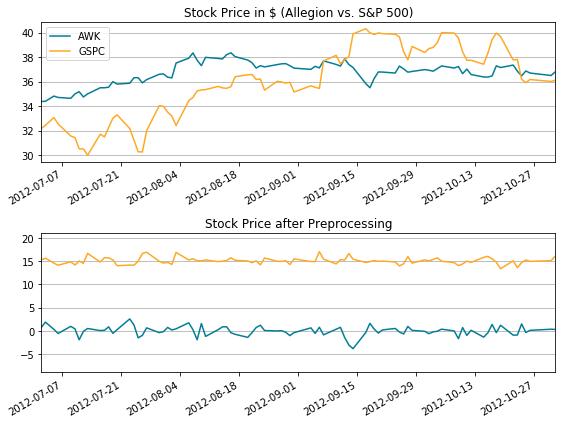

time: 1.12 s


In [67]:
# fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig, axes = plt.subplots(2, figsize=(8, 6))

comp_orig_price[selected_period].plot(ax=axes[0], color=plot.primary, title=f'Stock Price in $ ({securities.get_company_name(sym)} vs. S&P 500)', label=symbol)
vmin, vmax = comp_orig_price[selected_period].min().min(), comp_orig_price[selected_period].max().max()
temp_gspc = gspc.open[std_resid.index][selected_period]
gmin, gmax = temp_gspc.min(), temp_gspc.max()
axes[0].plot(30 + (temp_gspc - gmin) / (gmax - gmin) * vmin * 0.3, label='GSPC', color=plot.secondary)
axes[0].set_xlabel('')
axes[0].set_xlim((temp_gspc.index.min(), temp_gspc.index.max()))
axes[0].legend()
axes[0].yaxis.grid()

std_resid.plot(ax=axes[1], color=plot.primary, title='Stock Price after Preprocessing', label=sym)
axes[1].plot((gspc.otc[std_resid.index] - 1) * 100 + 15, label='GSPC', color=plot.secondary)
axes[1].set_xlabel('')
axes[1].set_xlim((temp_gspc.index.min(), temp_gspc.index.max()))
axes[1].yaxis.grid()

# fig.suptitle(f'Data Processing for {securities.get_company_name(sym)}')
fig.tight_layout()
# plt.subplots_adjust(top=0.87)

# fig.savefig('data-processing-awk-before-after-short-period.pdf')

##### Correlation Steps

In [320]:
print('Autocorrelated: ', comp_resid_chars[comp_resid_chars.autocorr != 0].index.tolist())
# Always KPSS, Can be fixed by taking greater parameters for ARIMA
print('Unit Root: ', comp_resid_chars[comp_resid_chars.unit_root != 0].index.tolist())
print('Amount of heteroscedastic: ', comp_resid_chars.groupby('heteroscedastic').count().loc[1][0])

Autocorrelated:  ['NI', 'GGP', 'CHK']
Unit Root:  ['MDT', 'PFE', 'CAT', 'FAST', 'FDX', 'LUV', 'BBY', 'RL', 'SIG', 'CA', 'CTSH', 'CTXS', 'FFIV', 'HRS', 'IBM', 'MU', 'STX', 'WDC', 'XLNX', 'ADM', 'KMB', 'ED', 'SO', 'BAC', 'DFS', 'L', 'PX', 'FTI', 'CTL']
Amount of heteroscedastic:  28
time: 224 ms


In [361]:
print('Significance for Pearson\'s r:')
crits = math_utils.r_critical_values(len(all_correlations), prec=4)
for p_value, pearson_r in crits.iteritems():
    print(f'> {p_value:6}: {pearson_r}')

((all_correlations > crits[0.001]) | (all_correlations < -crits[0.001])).sum() / len(all_correlations)

Significance for Pearson's r:
>    0.1: 0.005
>   0.05: 0.0059
>   0.01: 0.0078
>  0.001: 0.01
> 0.0001: 0.0118


Price         0.995028
Return        1.000000
Normalized    0.859150
Residuals     0.855768
dtype: float64

time: 514 ms


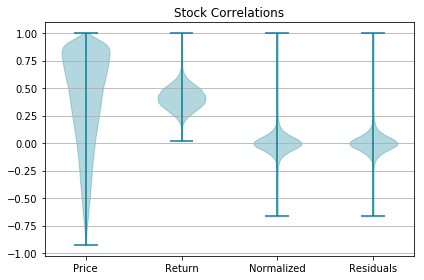

time: 2.42 s


In [88]:
fig = regr.plot_correlations(all_correlations)
fig.savefig('steps-correlations-ind-norm.pdf')

##### Correlation Steps with GSPC normalization

In [359]:
comp_symbols2, comp_resids2, comp_prices2, comp_orig_returns2, comp_orig_prices2, comp_resid_chars2 = calc_residuals_v2(all_industries, norm_gspc=True)

Are the characteristics the same as before? True
time: 9min 3s


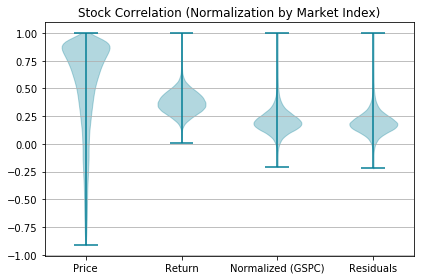

time: 2.27 s


In [91]:
# all_correlations2 = regr.calc_all_correlations(comp_symbols2, comp_resids2, comp_prices2, comp_orig_returns2, comp_orig_prices2)

fig = regr.plot_correlations(all_correlations2.rename({'Normalized': 'Normalized (GSPC)'}, axis=1))
plt.gca().set_title('Stock Correlation (Normalization by Market Index)')
fig.savefig('steps-correlations-gspc-norm.pdf')

Optional: export graph as PDF: https://stackoverflow.com/a/45863121/4816930

##### Validation Set

In [89]:
comp_symbols_val, comp_resids_val, comp_prices_val, comp_orig_returns_val, comp_orig_prices_val, comp_resid_chars_val = calc_residuals_v2(all_industries, val=True)

Are the characteristics the same as before? True
time: 5min 23s


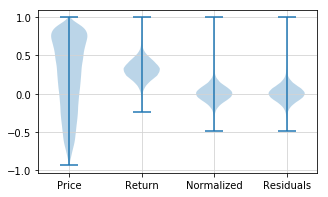

time: 7min 12s


In [95]:
all_correlations_val = regr.calc_all_correlations(comp_symbols_val, comp_resids_val, comp_prices_val, comp_orig_returns_val, comp_orig_prices_val)
fig = regr.plot_correlations(all_correlations_val)

In [ ]:
print(round(math_utils.correlation(all_correlations.Residuals, all_correlations_val.Residuals), 2))
# coor residuals - 99.9 Percentile: 0.3949
display_correlation_graph(all_correlations_val.Residuals, threshold=np.percentile(all_correlations_val.Residuals, 99.9),
                          layout_params={'k': 0.7, 'iterations': 200, 'seed': 42} , scaling_factor=1)
                          # output_file='graph-corr-resid-999-42')

##### Collect examples for spurious regression

                   industry                   name symbol
75   Consumer Discretionary              CBS Corp.    CBS
343               Utilities  Pinnacle West Capital    PNW 

                   industry                         name symbol
309                  Energy  National Oilwell Varco Inc.    NOV
379  Consumer Discretionary                 Snap-On Inc.    SNA 



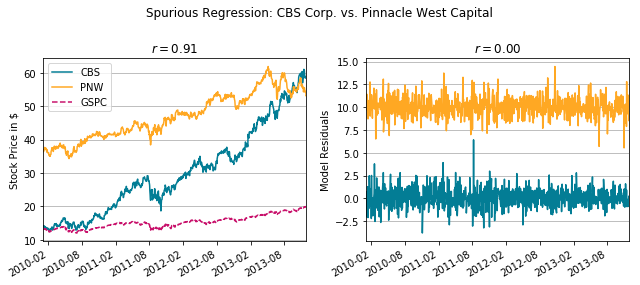

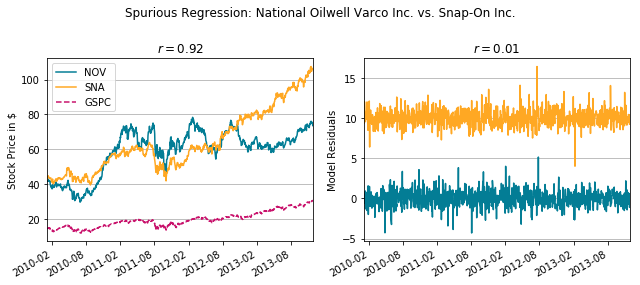

time: 1.8 s


In [80]:
def plot_spurious_regression(a, b):
    print(comp_metas[comp_metas.symbol.isin([a, b])], '\n')
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    comp_orig_prices[[a, b]].plot(ax=axes[0], color=[plot.primary, plot.secondary])
    vmin, vmax = comp_orig_prices[[a, b]].min().min(), comp_orig_prices[[a, b]].max().max()
    gmin, gmax = gspc.open.min(), gspc.open.max()
    axes[0].plot(12 + (gspc.open - gmin) / (gmax - gmin) * vmin, '--', label='GSPC', color=plot.ternary)
    axes[0].set_xlim((comp_orig_prices[[a, b]].index.min(), comp_orig_prices[[a, b]].index.max()))
    axes[0].set_title(fr'$r={all_correlations.Price[a][b]:.2f}$')
    axes[0].legend()
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Stock Price in $')
    axes[0].yaxis.grid()
    # Does not change the correlation
    # math_utils.abs_values(comp_resids[a] * 0.01)
    (comp_resids[[a, b]] + [0, 10]).plot(ax=axes[1], legend=False, color=[plot.primary, plot.secondary])
    # axes[1].plot(gspc.open / gspc.open.max() * comp_orig_prices[[a, b]].max().max() - 100, '--')
    axes[1].set_xlim((comp_orig_prices[[a, b]].index.min(), comp_orig_prices[[a, b]].index.max()))
    axes[1].set_title(fr'$r={all_correlations.Residuals[a][b]:.2f}$')
    axes[1].set_xlabel('')
    axes[1].set_ylabel('Model Residuals')
    axes[1].yaxis.grid()
    fig.suptitle(f'Spurious Regression: {securities.get_company_name(a)} vs. {securities.get_company_name(b)}')
    fig.tight_layout()
    plt.subplots_adjust(top=0.8)
    return fig, axes

l = (all_correlations.Price.abs() - all_correlations.Residuals.abs()).abs().sort_values(ascending=False)
for (a, b) in l[1000:1002].index:
    if a < b and a != 'GOOG':
        plot_spurious_regression(a, b)

                   industry             name symbol
169  Information Technology       Fiserv Inc   FISV
405              Financials  Torchmark Corp.    TMK 



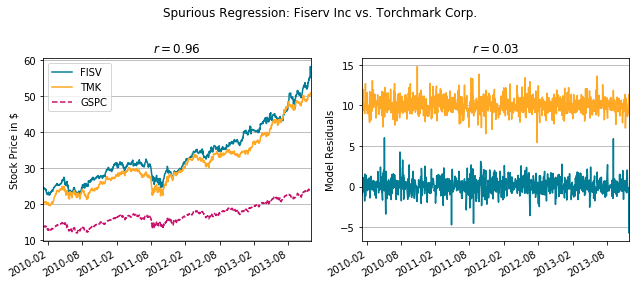

time: 1 s


In [81]:
examples = [['ADI', 'TWX'], ['NEE', 'VTR'], ['ACN', 'CAT'], ['FISV', 'TMK']]
for a, b in examples[-1:]:
    fig, axes = plot_spurious_regression(a, b)
    fig.savefig(f'spurious-{a}-{b}.pdf')

In [319]:
correlations_orig_prices[a][b], correlations_resid[a][b], \
math_utils.correlation(comp_resids[a] * 0.01, comp_resids[b] * 0.01), \
math_utils.correlation(math_utils.abs_values(comp_resids[a] * 0.01), math_utils.abs_values(comp_resids[b] * 0.01))
# math_utils.abs_values(comp_resids[a] * 0.01).plot()
# math_utils.abs_values(comp_resids[b] * 0.01).plot();

(0.9578280224040308,
 0.029982637016231876,
 0.02998263701623188,
 0.9024190417814139)

time: 289 ms


##### Find Show Case

In [21]:
merged = all_correlations

time: 164 ms


In [ ]:
merged[(merged['Same Industry'] == 0) & ((merged.Price - merged.Residuals) < -0.1)]

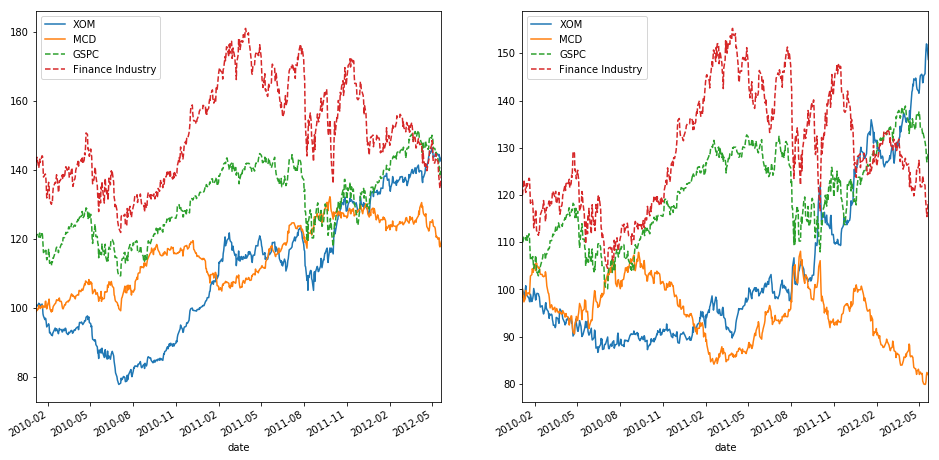

time: 733 ms


In [24]:
pair = ('XOM', 'MCD')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

math_utils.abs_values(comp_orig_returns.loc[:, pair]-1, 100).plot(ax=axes[0], xlim=(comp_prices.index.min(), comp_prices.index.max()))
math_utils.abs_values(gspc.otc - 1, 120).plot(ax=axes[0], linestyle='dashed', label='GSPC', legend=True)
math_utils.abs_values(ind_means[securities.get_industry(pair[0])], 140).plot(ax=axes[0], linestyle='dashed', label='Finance Industry', legend=True)
math_utils.abs_values(comp_prices.loc[:, pair], 100).plot(ax=axes[1], xlim=(comp_prices.index.min(), comp_prices.index.max()))
math_utils.abs_values(gspc.otc - 1, 110).plot(ax=axes[1], linestyle='dashed', label='GSPC', legend=True)
math_utils.abs_values(ind_means[securities.get_industry(pair[0])], 120).plot(ax=axes[1], linestyle='dashed', label='Finance Industry', legend=True)

Correlate CME and ICE:
Pearson's r = 0.44 (without preprocessing: 0.06)


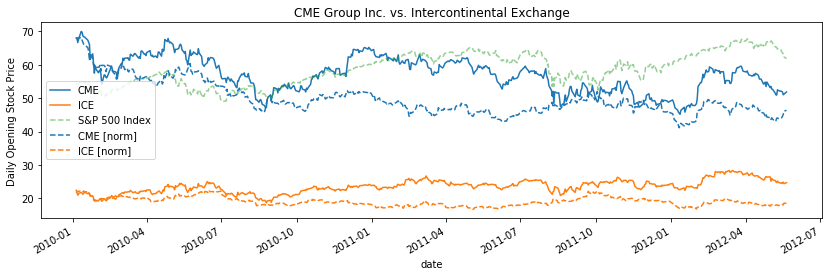

time: 787 ms


In [756]:
pair = ('CME', 'ICE')
plot.compare_industry_players(pair, correlations_resid.loc[pair], comp_prices, comp_orig_prices, gspc.open, securities)

In [ ]:
stack = energy_correlations.stack()
pair = stack.idxmax()
# price_resids
plot.compare_industry_players(pair, energy_correlations.loc[pair], ind_prices, ind_orig_prices, gspc.open, securities)

pair = stack.idxmin()
plot.compare_industry_players(pair, energy_correlations.loc[pair], ind_prices, ind_orig_prices, gspc.open, securities)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
a, b = stack.idxmax()
ind_orig_prices[a].plot(ax=axes[0], label='real', legend=True)
math_utils.abs_values(ind_prices[a], ind_orig_prices[a][0]).plot(ax=axes[0], label='normalized', legend=True, title=a)
(gspc.open / 20).plot(ls='--', ax=axes[0], label='gspc', legend=True)
axes[0].set_xlim((ind_prices[a].index[0], ind_prices[a].index[-1]))

ind_orig_prices[b].plot(ax=axes[1], label='real', legend=True)
math_utils.abs_values(ind_prices[b], ind_orig_prices[b][0]).plot(ax=axes[1], label='normalized', legend=True, title=b)
(gspc.open / 20).plot(ls='--', ax=axes[1], label='gspc', legend=True)
axes[1].set_xlim((ind_prices[b].index[0], ind_prices[b].index[-1]))

x = math_utils.abs_values(ind_prices[a])
y = math_utils.abs_values(ind_prices[b])
pd.concat([x, y], axis=1).plot(ax=axes[2], title=f'{a} vs {b} after subtracting the industry mean')
(gspc.open / gspc.open.max() * 100).plot(ls='--', ax=axes[2], label='GSPC', legend=True)
axes[2].set_xlim((x.index[0], x.index[-1]))
print('Final correlation: ', math_utils.correlation(*ind_prices.loc[:, stack.idxmax()].T.values))

#### Text-based Graph

In [5]:
pairwise_dist = pd.read_csv('../data/preprocessed/occurrences/pairwise_dist_with_people.csv', index_col=[0, 1], squeeze=True)  # header=None

time: 291 ms


In [ ]:
# 99.9 Percentile: 0.4985
# Co-occurrence: 90 edges, 98 nodes
display_correlation_graph(pairwise_dist / 2, threshold=np.percentile(pairwise_dist / 2, 99.9),
                          layout_params={'k': 0.7, 'iterations': 200, 'seed': 42} , scaling_factor=1)
                          # output_file='graph-pair-dist-999-42')

In [773]:
x = pairwise_dist[pairwise_dist >= np.percentile(pairwise_dist, 99.9)]
print(len(x))
x.index = x.index.remove_unused_levels()
s = pd.Series([sym2industry[y] for y in set(x.index.levels[0]).union(set(x.index.levels[1]))])
s.groupby(s).count()

90


Consumer Discretionary         18
Consumer Staples                6
Energy                          9
Financials                     15
Health Care                     9
Industrials                    14
Information Technology         16
Materials                       2
Real Estate                     3
Telecommunications Services     1
Utilities                       5
dtype: int64

time: 200 ms


In [778]:
sum([sym2industry[y] == sym2industry[z] for y, z in x.index])

28

time: 206 ms


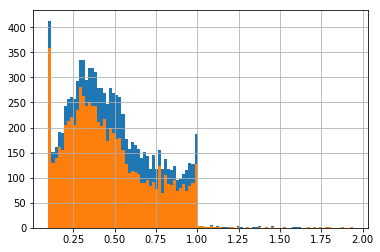

time: 15.3 s


In [723]:
ax = pairwise_dist[pairwise_dist > 0.1].hist(bins=100)
pairwise_dist[[pairwise_dist[x, y] > 0.1 and sym2industry[x] != sym2industry[y] for x, y in pairwise_dist.index]].hist(bins=100, ax=ax);

In [785]:
x = all_correlations.Residuals.abs()
x = x[x >= np.percentile(x, 99.9)]
x.index = x.index.remove_unused_levels()
x = set(x.index.levels[0]).union(set(x.index.levels[1]))

y = pairwise_dist
y = y[y >= np.percentile(y, 99.9)]
y.index = y.index.remove_unused_levels()
y = set(y.index.levels[0]).union(set(y.index.levels[1]))

len(x), len(y), len(x.intersection(y))

(123, 98, 29)

time: 200 ms


In [791]:
securities.get_company_name('NFLX')

'Amazon.com Inc'

time: 227 ms


### Export for Correlation

In [94]:
in_same_industry = pd.Series(index=all_correlations.index)
industry_map = dict([(sym, securities.get_industry(sym)) for sym in comp_symbols])
for a, b in tqdm(all_correlations.index):
    in_same_industry[a, b] = industry_map[a] == industry_map[b]

time: 5.33 s


In [96]:
all_correlations['Same Industry'] = in_same_industry.astype(int)
all_correlations.to_csv('../data/preprocessed/econometrics/correlations.csv')
all_correlations.drop('Same Industry', axis=1, inplace=True)

time: 1.92 s


In [632]:
all_correlations2['Same Industry'] = in_same_industry.astype(int)
all_correlations2.to_csv('../data/preprocessed/econometrics/correlations-gspc.csv')
all_correlations2.drop('Same Industry', axis=1, inplace=True)

time: 2.81 s


#### Calculate Correlations

In [35]:
pairwise_dist = pd.read_csv('../data/preprocessed/occurrences/pairwise_dist_with_people.csv', index_col=[0, 1], squeeze=True)  # header=None
all_correlations = pd.read_csv('../data/preprocessed/econometrics/correlations.csv', index_col=[0, 1])
all_correlations2 = pd.read_csv('../data/preprocessed/econometrics/correlations-gspc.csv', index_col=[0, 1])

def make_mergable(x):
    if len(x.shape) == 2:
        x = x.stack()
    return x[[a < b for a, b in x.index]]

merged = pd.concat([make_mergable(pairwise_dist).rename('Dist'),
                    make_mergable(all_correlations.Residuals).abs(),
                    make_mergable(all_correlations2.Residuals).abs().rename('Res2'),
                   ], axis=1).dropna(subset=['Residuals', 'Dist']).fillna(0)
stats.pearsonr(merged.Dist, merged.Residuals), stats.pearsonr(merged.Dist, merged.Res2)

((0.11053689099829554, 7.114809394689302e-234),
 (0.1256957387661379, 2.476848525931163e-302))

time: 3.38 s


### Compare Graphs

#### Setup

Execution requires running the initial setup (chapter 1) and the graph setup (chapter 5.1)

In [4]:
all_correlations = pd.read_csv('../data/preprocessed/econometrics/correlations.csv', index_col=[0, 1])
all_correlations.index.levels[1].name = None
all_correlations = all_correlations[[a < b for a, b in all_correlations.index]]
all_correlations.index = all_correlations.index.remove_unused_levels()
all_correlations = all_correlations.Residuals


# file_coocc = 'pairwise_dist_with_people.csv'
file_coocc = 'pairwise_dist.csv'
all_pairwise_dist = pd.read_csv(f'../data/preprocessed/occurrences/{file_coocc}', index_col=[0, 1], header=None, squeeze=True)  # header=None
all_pairwise_dist /= 2  # Since it's the addition of both distanves (people and company)
all_pairwise_dist.index.levels[0].name = None
all_pairwise_dist.index.levels[1].name = None


nodes_news = set(all_pairwise_dist.index.remove_unused_levels().levels[0]).union(
        set(all_pairwise_dist.index.remove_unused_levels().levels[1]))
nodes_stocks = set(all_correlations.index.remove_unused_levels().levels[0]).union(
        set(all_correlations.index.remove_unused_levels().levels[1]))
shared_nodes_set = set(nodes_news.intersection(nodes_stocks))
shared_nodes = list(shared_nodes_set)


all_correlations = all_correlations[[x for x in all_correlations.index if
                                     x[0] in shared_nodes_set and x[1] in shared_nodes_set]]
all_pairwise_dist = all_pairwise_dist[[x for x in all_pairwise_dist.index if
                                       x[0] in shared_nodes_set and x[1] in shared_nodes_set]]

time: 6.5 s


In [274]:
threshold_corr = np.percentile(all_correlations.abs(), 99.9)
threshold_pair_dist = np.percentile(all_pairwise_dist, 99.9)

time: 329 ms


In [ ]:
# coor residuals - 99.9 Percentile: 0.3654, 109 edges, 121 nodes
# After considering neg: 0.3688, 109 edges (incl. 4 neg.), 123 nodes, 11 industries, only 6 diff-industry edges
display_correlation_graph(all_correlations, threshold=threshold_corr,
                          layout_params={'k': 0.7, 'iterations': 250, 'seed': 42}, scaling_factor=1, debug=True)
    
# Threshold: 0.37
# Edges: 109
# Nodes: 123

In [ ]:
# 99.9 Percentile: 0.4985
# Co-occurrence: 90 edges, 98 nodes
display_correlation_graph(all_pairwise_dist, threshold=threshold_pair_dist,
                          layout_params={'k': 0.7, 'iterations': 200, 'seed': 42} , scaling_factor=1, debug=True)
# Threshold: 0.50
# Edges: 90
# Nodes: 98

#### Again Inspect Correlations

In [536]:
all_correlations_measures = pd.read_csv('../data/preprocessed/econometrics/correlations.csv', index_col=[0, 1])
all_correlations_measures.index.levels[1].name = None
all_correlations_measures = all_correlations_measures[[a < b for a, b in all_correlations_measures.index]]
all_correlations_measures.index = all_correlations_measures.index.remove_unused_levels()

time: 1.17 s


In [537]:
merged = pd.concat([# all_correlations.rename('Stock'),
                    *[all_correlations_measures[col].abs() for col in all_correlations_measures.columns],
                    all_pairwise_dist.rename('News')],
                   axis=1).dropna(subset=('Residuals', 'News')).fillna(0)
merged.index = merged.index.remove_unused_levels()

time: 2.23 s


In [539]:
all_correlations.shape, all_pairwise_dist.shape, merged.shape

((86736,), (86736,), (86736, 6))

time: 253 ms


In [540]:
merged.corr().round(4)

,Price,Return,Normalized,Residuals,Same Industry,News
Price,1.0000,0.1588,0.0827,0.0810,0.0601,-0.0037
Return,0.1588,1.0000,0.1715,0.1673,0.2868,0.1098
Normalized,0.0827,0.1715,1.0000,0.9866,0.2323,0.1261
Residuals,0.0810,0.1673,0.9866,1.0000,0.2391,0.1284
Same Industry,0.0601,0.2868,0.2323,0.2391,1.0000,0.1624
News,-0.0037,0.1098,0.1261,0.1284,0.1624,1.0000


time: 299 ms


In [164]:
merged.corr().round(4)

,Price,Return,Normalized,Residuals,Same Industry,News
Price,1.0000,0.1588,0.0827,0.0810,0.0601,-0.0028
Return,0.1588,1.0000,0.1715,0.1673,0.2868,0.1103
Normalized,0.0827,0.1715,1.0000,0.9866,0.2323,0.1289
Residuals,0.0810,0.1673,0.9866,1.0000,0.2391,0.1314
Same Industry,0.0601,0.2868,0.2323,0.2391,1.0000,0.1643
News,-0.0028,0.1103,0.1289,0.1314,0.1643,1.0000


time: 293 ms


Normalized Stocks:
- Count: 0.0945
- Min-Dist: 0.1124
- Min-Dist (w. People): 0.1155
- Pair-Dist: 0.1284
- Pair-Dist (w. People): 0.1314

Raw Stocks:
- Count: 0.003
- Min-Dist: -0.0240
- Min-Dist (w. People): -0.0225
- Pair-Dist: -0.0037
- Pair-Dist (w. People): -0.0028

Same Industry:
- Count: 0.0690
- Min-Dist: 0.1447
- Min-Dist (w. People): 0.1477
- Pair-Dist: 0.1624
- Pair-Dist (w. People): 0.1643

#### Compare Percentile

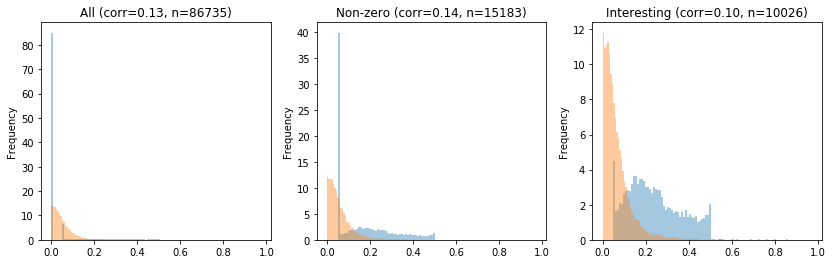

time: 2.28 s


In [124]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for step, title, ax in zip([-1, 0, 0.05], ['All', 'Non-zero', 'Interesting'], axes):
    dist_edges = all_pairwise_dist[all_pairwise_dist > step]
    corr_edges = all_correlations[dist_edges.index].abs()
    
    dist_edges.plot.hist(bins=100, histtype='stepfilled', alpha=0.4, ax=ax, normed=True)
    corr_edges.plot.hist(bins=100, histtype='stepfilled', alpha=0.4, ax=ax, normed=True)
    
    # shared_edges = dist_edges[dist_edges.index.isin(corr_edges.index)]
    # shared_edges.plot.hist(bins=100, histtype='stepfilled', alpha=0.4, ax=ax, normed=True)
    
    correlation = pd.concat([dist_edges.rename('News'), corr_edges.rename('Stock')], axis=1).corr().iloc[0, 1]
    
    ax.set_title(f'{title} (corr={correlation:.2f}, n={len(dist_edges)})')

fig.savefig('../reports/custom/distributions.png')

In [128]:
percentage_steps = np.arange(100, 0, -0.2)
# percentage_steps = 100 - np.concatenate([[0], np.logspace(-1, 2, 60)])
percentage_steps = [round(x, 5) for x in percentage_steps]
shared_stats = pd.DataFrame(index=percentage_steps, columns=['nodes', 'edges', 'total_edges', 'corr'])

for percentage in tqdm(percentage_steps):
    # theta_corr = round(np.percentile(all_correlations.abs(), percentage), 5)
    # theta_dist = round(np.percentile(all_pairwise_dist, percentage), 5)
    # dist = all_pairwise_dist[all_pairwise_dist >= theta_dist]
    n_edges = max(int((1 - percentage / 100) * len(all_pairwise_dist)), 1)
    dist = all_pairwise_dist[np.argpartition(all_pairwise_dist, -n_edges)[-n_edges:]]
    theta_dist = min(dist)
    n_edges = len(dist)
    
    corr = all_correlations[np.argpartition(all_correlations, -n_edges)[-n_edges:]]
    theta_corr = min(corr)
    
    shared_edges = len(dist[dist.index.isin(corr.index)])
    
    nodes_dist = set(dist.index.remove_unused_levels().levels[0]).union(
        set(dist.index.remove_unused_levels().levels[1]))
    nodes_corr = set(corr.index.remove_unused_levels().levels[0]).union(
        set(corr.index.remove_unused_levels().levels[1]))
    shared_nodes = len(nodes_dist.intersection(nodes_corr))
    
    merged = pd.concat([dist.rename('News'), corr.rename('Stocks')],
                   axis=1).dropna().fillna(0)
    merged.index = merged.index.remove_unused_levels()
    correlation = pd.concat([dist, corr], axis=1).corr().iloc[0, 1]
    
    shared_stats.loc[percentage] = (shared_nodes, shared_edges, len(dist), correlation or 0)

time: 14min 54s


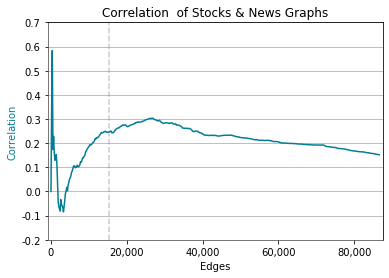

time: 602 ms


In [181]:
ax = plot.create_plot(list(shared_stats.total_edges), 'Edges', shared_stats['corr'], 'Correlation',
                      title='Correlation  of Stocks & News Graphs')
ax.axvline(sum(all_pairwise_dist != 0), color='gray', alpha=0.4, linestyle='--');
# plot.save_plot(ax.get_figure(), "correlation-steps", "../reports/custom")

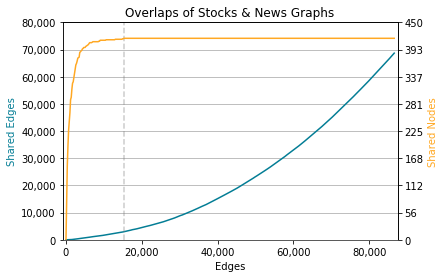

time: 768 ms


In [180]:
ax = plot.create_plot(list(shared_stats.total_edges), 'Edges', shared_stats.edges, 'Shared Edges',
                      shared_stats.nodes, 'Shared Nodes', y1_lim=(0, None), y2_lim=(0, None),
                      title='Overlaps of Stocks & News Graphs')
ax.axvline(sum(all_pairwise_dist != 0), color='gray', alpha=0.4, linestyle='--');
# plot.save_plot(ax.get_figure(), "shared-nodes-and-edges", "../reports/custom")

#### Mixed-Membership Block Models

- Set up adjacency matrices and find a good order to detect communities

In [292]:
comps = np.concatenate([list(get_industry(x)) for x in comp_metas.industry.unique()]) 
comp_symbols = [x[0] for x in comps]
in_same_industry = pd.Series(index=all_correlations.index)
sym2ind = dict([(sym, securities.get_industry(sym)) for sym in comp_symbols])
for a, b in tqdm(all_correlations.index):
    in_same_industry[a, b] = sym2ind[a] == sym2ind[b]

time: 6.65 s


In [837]:
def to_adjacency_matrix(stack):
    unstacked = stack.unstack()
    am = unstacked.T.fillna(0) + unstacked.fillna(0)

    first_comp = sorted(shared_nodes)[0]
    last_comp = sorted(shared_nodes)[-1]

    am.loc[first_comp].iloc[1:] = unstacked.loc[first_comp]
    am.loc[:, first_comp].iloc[1:] = unstacked.loc[first_comp]

    am.loc[last_comp].iloc[1:] = unstacked.loc[:, last_comp]
    am.loc[:, last_comp].iloc[1:] = unstacked.loc[:, last_comp]

    np.fill_diagonal(am.values, 0)
    return am
    
am_stocks = to_adjacency_matrix(all_correlations.abs())
am_stocks /= am_stocks.max().max()
am_news = to_adjacency_matrix(all_pairwise_dist)
am_news /= am_news.max().max()
am_ind = to_adjacency_matrix(in_same_industry.astype(float))

time: 904 ms


In [846]:
sorted_by_ind = sorted(list(am_ind.index), key=lambda x: sym2ind[x])
assignment = pd.DataFrame([sorted_by_ind, [sym2ind[x] for x in sorted_by_ind]], index=['sym', 'ind']).T
ind_count = assignment.ind.value_counts()
ind_pivot = assignment.groupby('ind').first().sym.to_dict()
assignment.groupby('ind').first()

,sym
ind,
Consumer Discretionary,AAP
Consumer Staples,ADM
Energy,APA
Financials,AFL
Health Care,A
Industrials,AAL
Information Technology,AAPL
Materials,ALB
Real Estate,AMT


time: 381 ms


In [847]:
sorted_by_ind_and_corr = sorted(
    list(am_ind.index), key=lambda x: (sym2ind[x], 1 - am_stocks.loc[ind_pivot[sym2ind[x]], x]))
sorted_by_ind_and_dist = sorted(
    list(am_ind.index), key=lambda x: (sym2ind[x], 1 - am_news.loc[ind_pivot[sym2ind[x]], x]))

time: 427 ms


In [848]:
order = sorted_by_ind_and_corr

am_stocks = am_stocks.loc[order, order]
am_news = am_news.loc[order, order]
am_ind = am_ind.loc[sorted_by_ind, sorted_by_ind]
# am_diff = ((am_stocks - am_news + 1) / 2).loc[order, order]
# am_diff = (am_news - am_stocks).abs().loc[order, order]
am_diff = (am_news - am_stocks).loc[order, order]
am_sum = (am_stocks / 2 + am_news / 2).loc[order, order]

time: 795 ms


In [849]:
sorted_ind = assignment.ind.unique()
sorted_counts = np.array([ind_count[x] for x in sorted_ind])

xlabel_pos = sorted_counts.cumsum() - sorted_counts / 2
ylabel_pos = xlabel_pos.copy()
ylabel_pos[-5:] -= [12, 22, 18, 6, -6]

time: 332 ms


In [854]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

time: 280 ms


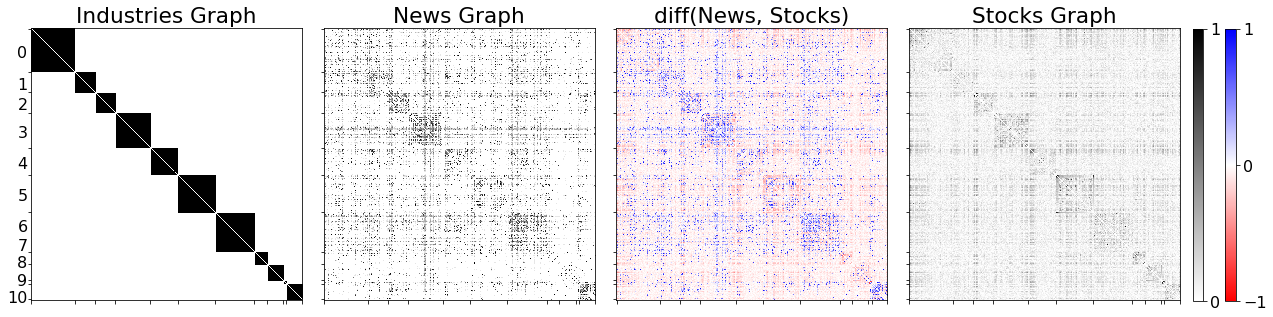

time: 1.76 s


In [867]:
plt.rc('font', size=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
# plt.rcParams.update({'ytick.labelsize': 30})

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for ax, am, title in zip(np.array(axes).flat, [am_ind, am_news, am_diff, am_stocks, am_sum], ['Industries Graph', 'News Graph', 'diff(News, Stocks)', 'Stocks Graph', 'Stocks + News']):
    if am is am_diff:
        im_bwr = ax.imshow(am, vmin=-1, vmax=1, cmap='bwr_r')
    else:
        im_gray = ax.imshow(am, vmin=0, vmax=1, cmap='gray_r')
    ax.set_title(title)
    ax.xaxis.set_major_locator(plt.FixedLocator(np.concatenate([[0], sorted_counts.cumsum() - 1, [len(am)]])))
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_minor_formatter(plt.NullFormatter())
    
    ax.yaxis.set_major_locator(plt.FixedLocator(np.concatenate([[0], sorted_counts.cumsum() - 1, [len(am)]])))
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_minor_locator(plt.FixedLocator(ylabel_pos))
    ax.tick_params(which='minor', length=0)
    ax.yaxis.set_minor_formatter(plt.NullFormatter())
axes[0].yaxis.set_minor_formatter(plt.FixedFormatter(np.arange(len(sorted_ind)).round().tolist()))

fig.tight_layout()
fig.subplots_adjust(right=0.92)

cbar_ax = fig.add_axes([0.93, 0.12, 0.008, 0.756])
cbar = fig.colorbar(im_gray, cax=cbar_ax)
cbar.set_ticks([0, 1])

cbar_ax = fig.add_axes([0.955, 0.12, 0.008, 0.756])
cbar = fig.colorbar(im_bwr, cax=cbar_ax)
cbar.set_ticks([-1, 0, 1])
fig.savefig('../reports/custom/adjacency-matrices-corr-sorted-diff.pdf')

### Binary Features

In [261]:
pairwise_dist = pd.read_csv('../data/preprocessed/occurrences/pairwise_dist_with_people.csv', index_col=[0, 1], squeeze=True)  # header=None

time: 343 ms


In [262]:
all_correlations = pd.read_csv('../data/preprocessed/econometrics/correlations.csv', index_col=[0, 1])

time: 468 ms


In [269]:
def make_mergable(x):
    if len(x.shape) == 2:
        x = x.stack()
    return x[[a < b for a, b in x.index]]

# comp_coocc[comp_coocc > 0] -> only 15.000 samples but higher correlation
merged = pd.concat([pairwise_dist.rename('Pairwise Distance'),  # 429
                    *[all_correlations[col].abs() for col in all_correlations.columns]  # 466
                   ], axis=1).dropna(subset=['Pairwise Distance', 'Price']).fillna(0)
merged.index = merged.index.remove_unused_levels()
merged.drop('Same Industry', axis=1, inplace=True)

time: 784 ms


In [270]:
merged.corr().round(4)

,Pairwise Distance,Price,Return,Normalized,Residuals
Pairwise Distance,1.0000,-0.0131,0.0936,0.1091,0.1105
Price,-0.0131,1.0000,0.1783,0.0418,0.0398
Return,0.0936,0.1783,1.0000,0.1296,0.1299
Normalized,0.1091,0.0418,0.1296,1.0000,0.9882
Residuals,0.1105,0.0398,0.1299,0.9882,1.0000


time: 215 ms


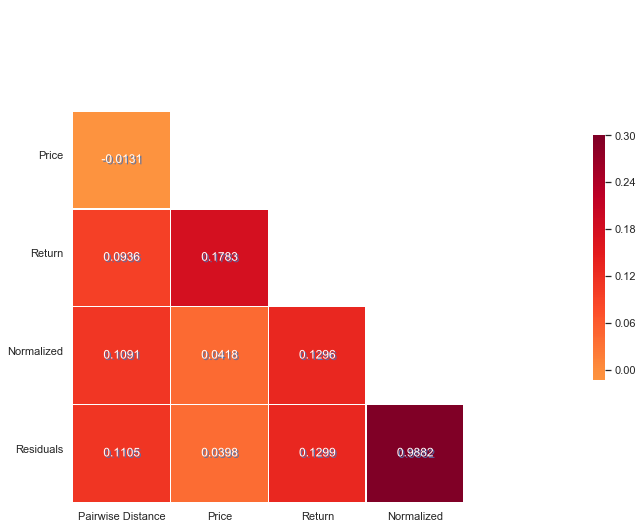

time: 719 ms


In [311]:
from string import ascii_letters
import seaborn as sns

sns.set(style="white")

# Generate a large random dataset
d = merged

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='YlOrRd', vmax=.3, center=0,  # "RdYlGn"
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), rotation=0, ha='right', rotation_mode='anchor')
ax.set_xticks(ax.get_xticks()[:-1])
ax.set_yticklabels(ax.get_yticklabels()[1:])
ax.set_yticks(ax.get_yticks()[1:])
for i in range(len(corr.columns)):
        for j in range(len(corr.index)):
            if i < j:
                ax.text(i+0.5, j+0.5, f'{corr.iloc[j, i]:.4f}', ha='center', va='center', color='w',
                        path_effects=[path_effects.withSimplePatchShadow(
                            offset=(1.5, -1.5), shadow_rgbFace='b', alpha=0.9)])
f.savefig('final-corr.pdf')

In [ ]:
# all_correlations = regr.calc_all_correlations(comp_symbols, comp_resids, comp_prices, comp_orig_returns, comp_orig_prices)

### TO READ

- https://shishirshakya.blogspot.com/2015/06/the-todayamamoto-approach-to-granger.html
- On Plotting https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

In [ ]:
def inspect_forecast(model_fit, train, val):
    # multi-step out-of-sample forecast
    start_index = len(train)
    end_index = start_index + len(val) - 1
    ex_sample_forecast = model_fit.predict(start=start_index, end=end_index)
    ex_sample_forecast.index = val.index

    in_sample_forecast = model_fit.predict(len(train)-101, len(train)-1)

    plt.plot(train.iloc[-100:])
    plt.plot(val, 'b--', alpha=0.2)
    plt.plot(in_sample_forecast, color='orange', alpha=0.2)
    plt.plot(ex_sample_forecast, color='orange')

inspect_forecast(model_fit, train, val)